# Project: Deep Learning-Based Evaluation of Under-Rotation in Figure Skating Jumps



*   Course: MIE1517
*   Group: 9
*   Members: Sylvia Ding, Keyin Liang, Shuo Cai
*   Version 2: 2025-12-07



In figure skating competitions, judging accuracy and fairness are essential but often limited by human perception. One of the most common judging errors arises from under-rotations—cases where a skater's jump rotation is slightly insufficient upon landing. Detecting such under-rotations by eye is difficult, particularly in fast multi-rotation jumps and when camera angles change. Consequently, athletes may receive inconsistent scores.

Our project aims to build an deep learning-based system that can automatically determine whether a jump is under-rotated using motion data extracted from video.

This approach has two main goals:


1.   provide a transparent, physics-consistent method of evaluating jump rotation
2.   reduce the bias introduyced by human judgement

Ultimately, our system could serve as a tool to assist technical specialists in real-time scoring or post-event video review.


![system workflow.png](<attachment:system workflow.png>)
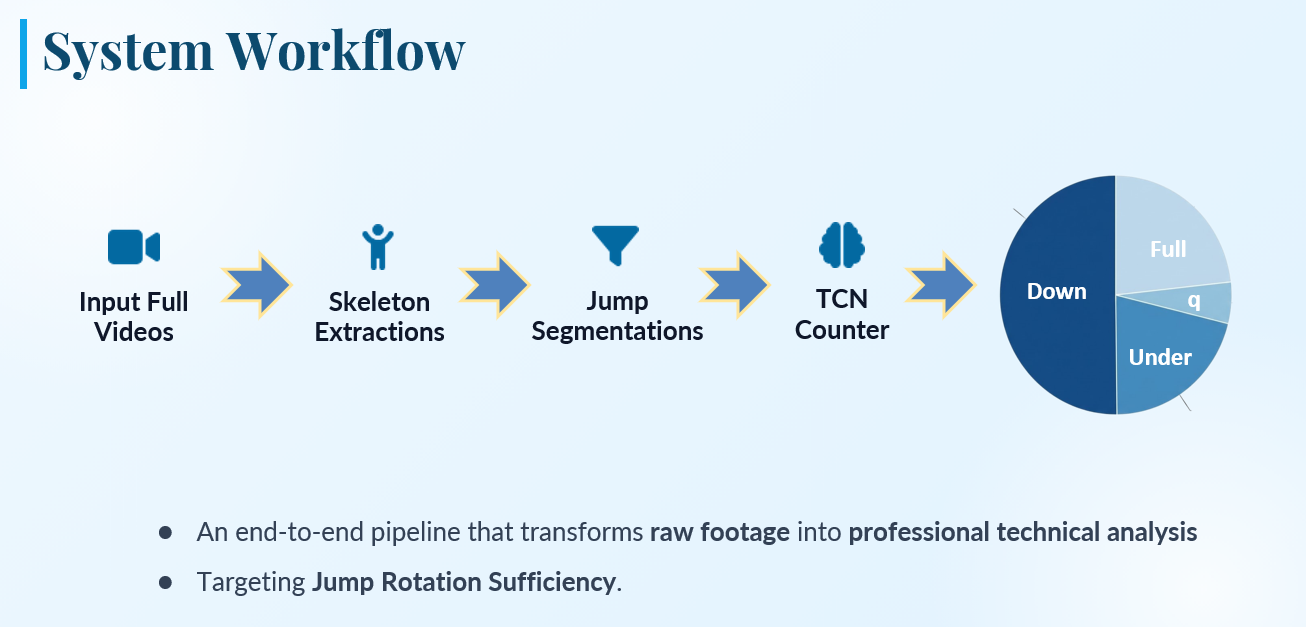

# Part A. Jump Segmentation

This part explains how we can obtain jump clips from a full program video of figure skating.

In a full program videos, we have jumps, spins, step sequences, choreography sequences and some other transitions. We need an automatic way to seperate jumps from the rest of the elements.

Related code can be found in Jump_candidates_segmentation.py. It can be run locally, only edits required are the video and output path. 

### Dataset:
Kaggle: 
https://www.kaggle.com/datasets/sarazany/figure-skating-underrotations-and-flutzlip/data
https://www.kaggle.com/datasets/betessawildenboer/lutz-jumps-dataset

Youtube Video:
2025 IDF WOMEN FS https://youtu.be/XlCM3GohF78
2025 IDF MEN FS https://youtu.be/ow7BhOBIk7A
2025 COC WOMEN FS https://youtu.be/sxbEiRGy8Z8
2025 COC MEN FS https://youtu.be/S1iE1Kh--HI
2025 NHK MEN FS https://youtu.be/deD0tqeaPoI

## 1. Skeleton Extraction
We run **MediaPipe Pose** on the full routine video at ~cache_fps to get skeleton keypoints, and save all **33 anatomical landmarks** into a compressed npz file.
- Model complexity for mediapipe pose is 1 here.

The cache will contain:
    keypoints: (T, 33, 4) array, [x, y, z, visibility], normalized [0,1]
    times:     (T,) time in seconds from start of video
    frame_idx: (T,) original frame index in the video
    metadata:  dict with video info and cache settings


We use the x and y coordinates for the following pose analysis. 

Related code can be found in the function **build_pose_cache**

## 2. Physics-Based Heuristics
Before using heavy AI models, we filter for potential jump segments based on figure skating physics

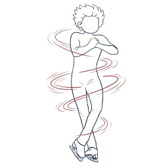
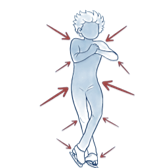


As we can see the jumps here, Skaters must minimize their moment of inertia to rotate, and the angular velocity is distinctive.

so we measure the tightness of limbs towards the central axis and the rotational speed to get the jump candidates.

### Here are the two-stage heuristic for jump candidate detection:

### Stage 1 (compactness):
        - Compute a "tucked limbs" compactness score:
            * Torso axis defined by mid-hips -> mid-shoulders.
            * Arms: wrists close to torso axis.
            * Legs: knees and ankles close to torso axis.
        - Rank frames by this compactness and keep the top compact_top_ratio.

### Stage 2 (rotation):
        - Compute body orientation angle in the image plane (using shoulders or hips).
        - Compute angular velocity |d(angle)/dt|.
        - Among the compact frames, keep the subset with highest angular velocity
          (rot_top_ratio).

### Then:
        - Group selected frames into temporal segments.
        - Extend, merge, and filter short segments.
        - Convert times back to original frame indices.

Related code can be found in the function **detect_jump_segments_by_compact_and_rotation_from_cache**  
Select the top 20% most compact frames and top 10% fastest-rotating among compact frames as the jump candidates. 
Then save jump clips and export the skeleton for each clip. Related code can be found in the function **save_segments_as_clips**


## 3. Two-Beanch LSTM Model for Binary Classification

Build a two-branch LSTM network for jumps & non-jumps classification.
The network combines both skeleton data and specific features, achieving 90% accuracy

### 3.1 Two-branch LSTM:
      - Branch 1: processes normalized joint coordinates.
      - Branch 2: processes engineered features.
      - Final head: merges both branches and predicts jump / non-jump.
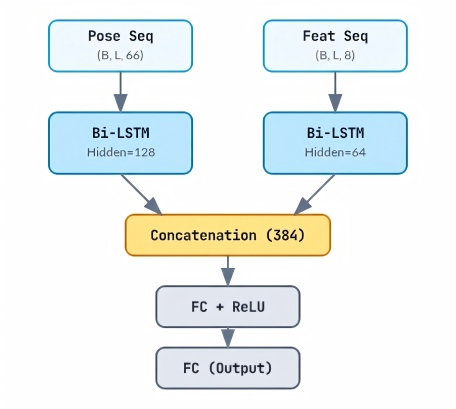

####  The feature list:
      - hip_up: hip height relative to baseline
      - ankle_up: ankle height relative to baseline
      - compact: how close arms/legs are to the body center
      - straight: trunk verticality
      - arms_up: hand height relative to shoulders
      - arms_front: hand forward distance to shoulders
      - abs_omega: absolute angular velocity (yaw rate)
      - ankle_angle: knee-ankle-toe angle in degrees (bigger in jumps, ~<=90 on ice)

Model code can be found in Building_LSTM_Model.py. 

### 3.2 Train the LSTM Model and plot the training curves

### Dataset: 
https://drive.google.com/drive/folders/1T9triWuKSeDZ6JV0Kix9V7i4D7Pbf48o?usp=sharing

- [Dataset] Found 1251 jump clips, 1172 non-jump clips
- [Dataset] train samples: 1875
- [Dataset] val samples: 469
- [Info] pose_dim=66, feat_dim=8

In [ ]:
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from Building_LSTM_Model import TwoBranchLSTM, collate_fn, train_one_epoch, eval_one_epoch, FSClipsDataset, evaluate_on_labeled_test_set, predict_on_unlabeled_folder

# =========================
# Main training script
# =========================

if __name__ == "__main__":
    # DATA_ROOT/
    #   jumps/*.npz
    #   non-jumps/*.npz
    DATA_ROOT = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/lstm_data"

    batch_size = 16
    max_len = 64
    num_epochs = 30
    lr = 1e-3
    val_fraction = 0.2

    train_dataset = FSClipsDataset(
        root_dir=DATA_ROOT,
        split="train",
        val_fraction=val_fraction,
        random_seed=42
    )
    val_dataset = FSClipsDataset(
        root_dir=DATA_ROOT,
        split="val",
        val_fraction=val_fraction,
        random_seed=42
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda b: collate_fn(b, max_len=max_len)
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda b: collate_fn(b, max_len=max_len)
    )

    # Infer input dimensions from one sample
    sample_item = train_dataset[0]
    pose_dim = sample_item["pose_seq"].shape[1]
    feat_dim = sample_item["feat_seq"].shape[1]
    print(f"[Info] pose_dim={pose_dim}, feat_dim={feat_dim}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TwoBranchLSTM(
        pose_dim=pose_dim,
        feat_dim=feat_dim,
        pose_hidden=128,
        feat_hidden=64,
        num_layers=1,
        dropout=0.1
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    # ---- lists to store history ----
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            f"Epoch {epoch:02d}: "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = os.path.join(DATA_ROOT, "best_two_branch_lstm.pt")
            torch.save(model.state_dict(), save_path)
            print(f"  -> New best model saved to {save_path} (val_acc={val_acc:.3f})")

    # ---- plot loss curves ----
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- plot accuracy curves ----
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 3.3 Load the best model for testing
We fine tuned several parameters and kept only the best one here.

In [ ]:
DATA_ROOT = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/lstm_data"
MODEL_PATH = os.path.join(DATA_ROOT, "best_two_branch_lstm.pt")

tmp_dataset = FSClipsDataset(
    root_dir=DATA_ROOT,
    split="train",
    val_fraction=0.2,
    random_seed=42,
)
sample_item = tmp_dataset[0]
pose_dim = sample_item["pose_seq"].shape[1]
feat_dim = sample_item["feat_seq"].shape[1]
print(f"[Info] pose_dim={pose_dim}, feat_dim={feat_dim}")

pose_hidden = 128
feat_hidden = 64
num_layers  = 1
dropout   = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TwoBranchLSTM(
    pose_dim=pose_dim,
    feat_dim=feat_dim,
    pose_hidden=pose_hidden,
    feat_hidden=feat_hidden,
    num_layers=num_layers,
    dropout=dropout
).to(device)

state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("[Info] Loaded model from", MODEL_PATH)


### 3.4 Evaluate on Test Dataset

In [ ]:
TEST_ROOT = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/2025SA_WOMEN_clip_coords_test"

test_acc, (tn, fp, fn, tp), buckets = evaluate_on_labeled_test_set(
    model=model,
    test_root=TEST_ROOT,
    device=device,
    max_len=64,
    batch_size=16,
    threshold=0.5,
    max_show_tp_tn=5,   # how many TP/TN examples to print
)


### 3.5 Evaluate on Unlabeled new data

In [ ]:
UNLABELED_FOLDER = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/2025SA_WOMEN-seg11_clip_coords_unlabeled"

predict_on_unlabeled_folder(
    model=model,
    folder=UNLABELED_FOLDER,
    device=device,
    max_len=64,
    threshold=0.5,
)

# Part B 
## 1. Data Preparation

This part explains the data sources we used, the structure of the data, and how we transformed the raw video data into skeletal features that could be used by the model.



### 1.1 Dataset Description

The dataset used in this project is the “Figure Skating Under-rotations and Flutz/Lip” dataset publicly available on [Kaggle](https://www.kaggle.com/datasets/sarazany/figure-skating-underrotations-and-flutzlip/data)
.


It consists of short video clips extracted from international figure skating competitions, categorized by specific technical judging issues such as under-rotations and flutz/lip errors.

For this project, we focus exclusively on the under-rotation subset.
This folder contains four subcategories corresponding to the degree of rotation completion, aligned with official ISU (International Skating Union) notation:



*   **0_full rotation:** Fully rotated jumps with no deductions

*   **1_on the quarter:** Slightly short (~¼ turn missing)

*   **2_underrotated:** Noticeably short (~¼–½ turn missing)

*   **3_downgraded:** Severely short (≥½ turn missing)


**Additional Data Source (Manual Annotation):**
To incorporate the latest high-level competition standards, we manually annotated and sliced the 2025 World Team Trophy Men Free Skating video (available [here](https://youtu.be/co7xNl9Wkuc)). These custom-sliced clips were integrated into the dataset to improve the model's exposure to top-tier technical executions.

**Data Preprocessing (Binary Classification):**
To focus on the detection of *any* rotation fault, we simplified the problem into a binary classification task. We applied the following mapping to group the labels:

* **Class 0 (Clean):** Includes `"full"`
* **Class 1 (Fault):** Merges `"q"`, `"under"`, and `"down"`

**Data Augmentation & Balancing:**
The original dataset presented a class imbalance. To address this, we applied data augmentation techniques (`data_augmentation.py` available in our [GitHub Repository](https://github.com/Sheweycs/FS-Jump-Rotation-Analysis.git)).
* **Mirroring (Horizontal Flip):** Creating new samples by flipping the jump direction.
* **Rotation:** Applying slight rotational variances to simulate different camera angles.

> **Final Dataset Status:**
> * **Class 0:** 500 samples
> * **Class 1:** 500 samples
> * **Total:** 1000 balanced samples

This combined and balanced dataset serves as the foundation for our deep learning model.

Despite these limitations, the dataset provides a valuable foundation for building a model that can learn under-rotation detection from real-world competition footage.


### 1.2 2D Pose Extraction (MediaPipe)

Accurately capturing the motion dynamics of a figure skating jump requires reliable skeletal information across time. 

- We first run MediaPipe Pose with model_complexity=1 on the full video to efficiently detect and localize candidate jump segments. After these segments are identified, we re-run Pose with the Heavy model (model_complexity=2) only on those short clips, because the higher-precision keypoints are more important for accurate rotation and technique analysis, while applying the Heavy model to the entire video would be computationally expensive and unnecessary.

**Code Availability:**
All data processing scripts are available in our [GitHub Repository](https://github.com/Sheweycs/FS-Jump-Rotation-Analysis.git).

To extract pose keypoints from raw videos, we use **MediaPipe Pose**, a deep-learning-based human pose estimation framework that detects **33 anatomical landmarks** per frame, which improves on the baseline MediaPipe Pose pipeline in three main ways:

1.   **Visibility Enhancement** — The skeleton is drawn using deeper, high-contrast colors (dark blue and dark red) with thicker lines to improve visibility
2.   **Reliability Filtering** — Early or low-confidence frames are automatically skipped or replaced with the last reliable pose, stabilizing the extracted sequence.
3.   **Standardized Output Format** — We provide two specific scripts for different needs:

*   `skeleton_video_extraction.py`: Use this if you want to **generate and visualize** the annotated videos with skeletal overlays (`_SK.mp4`).
*   `coords_extraction.py`: Use this if you only need to **process data** and extract the coordinate files (`_SK_coords.npz`) for model training.

The goal is to transform raw figure skate jump  clips into structured, standardized motion data suitable for statistical or machine-learning analysis.


### 1.3 Final Dataset

The preprocessing was executed offline to handle the large dataset efficiently and to ensure stable GPU-accelerated performance.  

The resulting keypoints were saved as `.npz` files, each containing a 3D tensor:

$$shape: (T, 33, 3) → (time, joints, [x, y, visibility])$$

These preprocessed files are now directly imported into our notebook for analysis and modeling, avoiding the need to rerun the computationally intensive pose extraction step.  

**Dataset Availability:**
The final balanced dataset, obtained through the steps above, is available at the following link: [Link to Dataset](https://drive.google.com/drive/folders/109k990G0kwnK4AUNeTZTw-EfT24T_YAT?usp=share_link).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


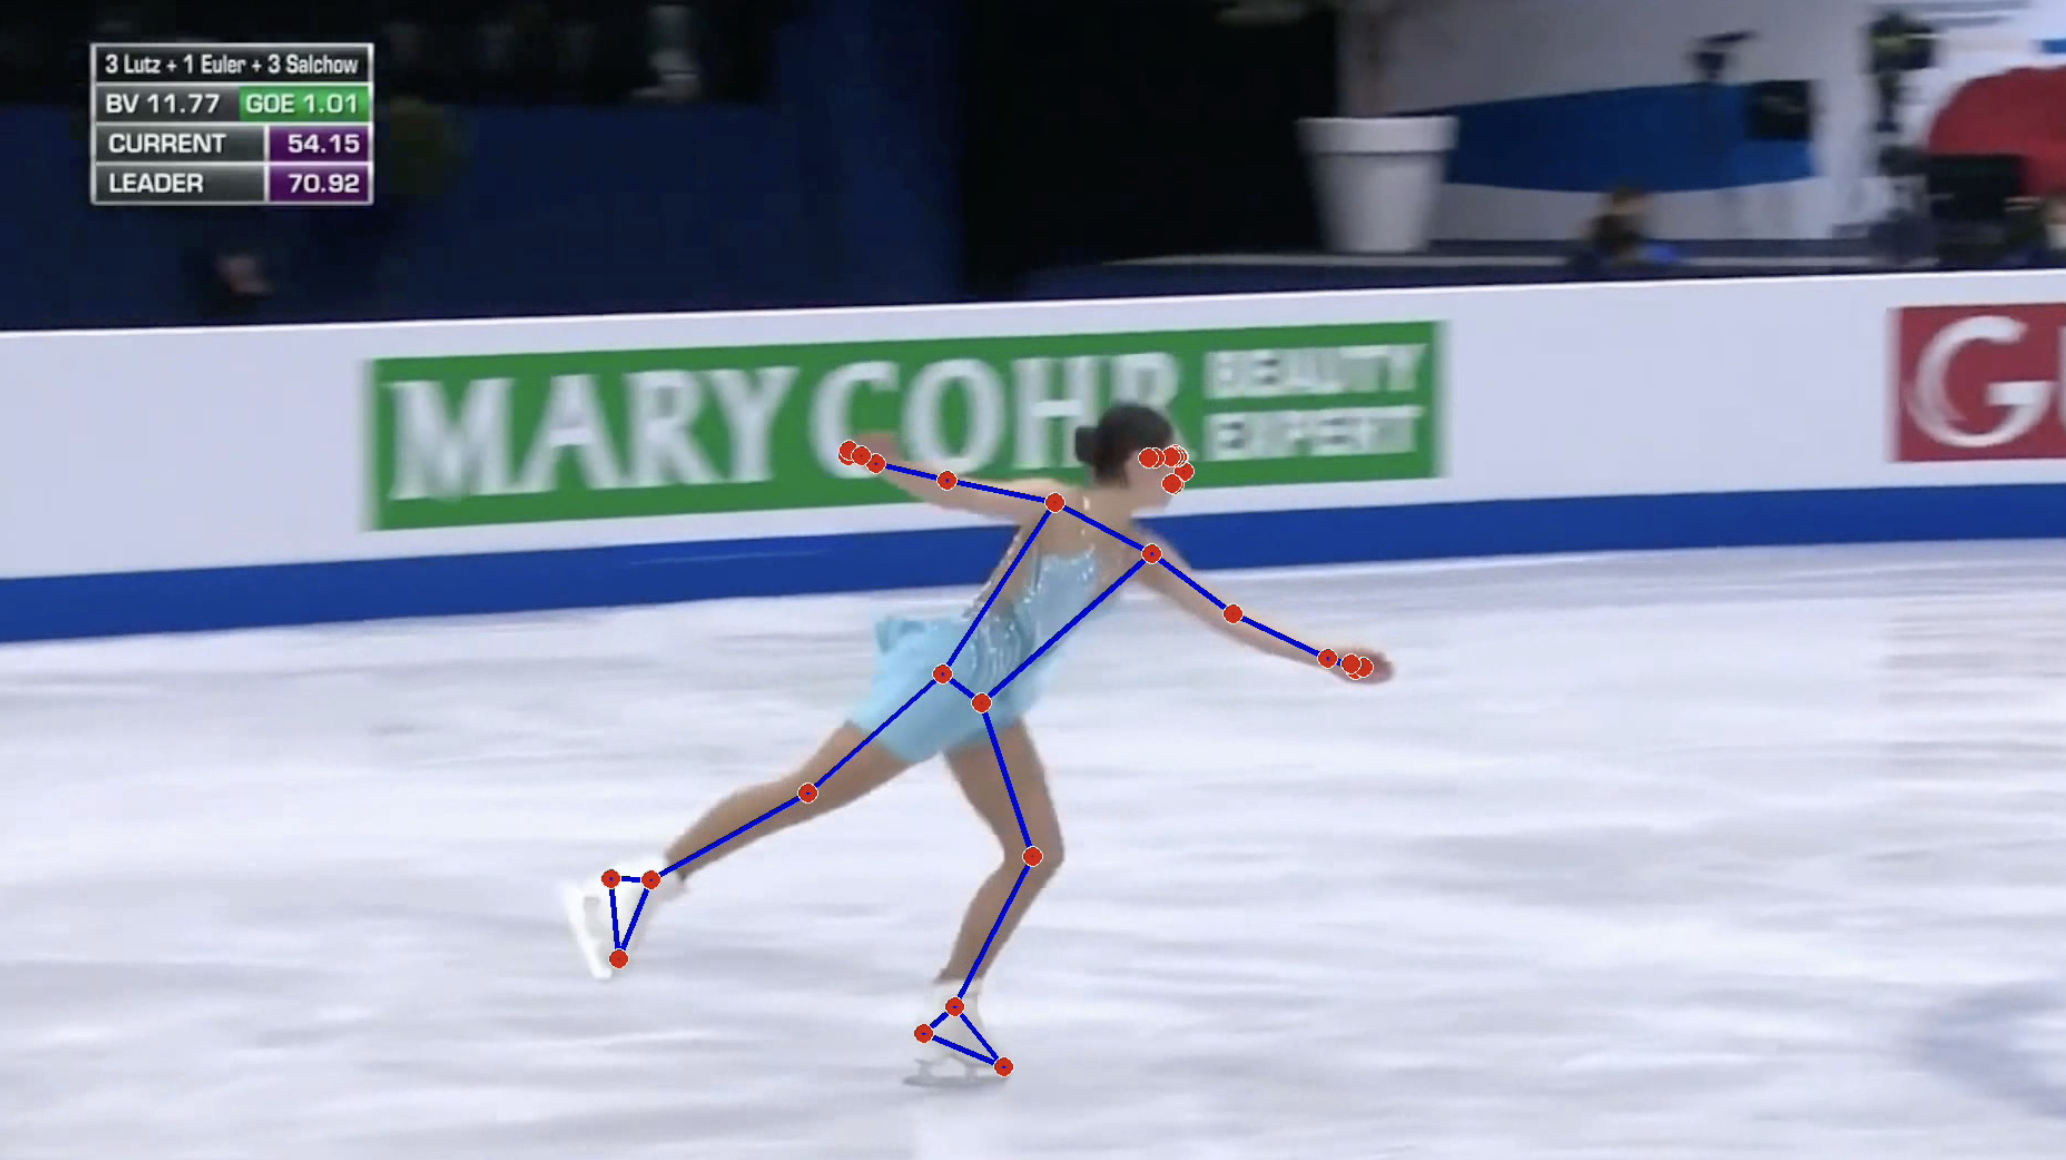

## 2. Model Architecture

Our challenge is to model how the human body moves through time — not just what it looks like in one frame. Subtle variations in timing, coordination, and joint trajectories often distinguish good rotations or landings from poor ones. Thus, the model must capture temporal dependencies: how earlier body positions influence later ones.

Among several models that can handle time series(i.e. RNN), we adopted **TCNs** because they combine efficiency, stability, and interpretability for medium-length motion sequences

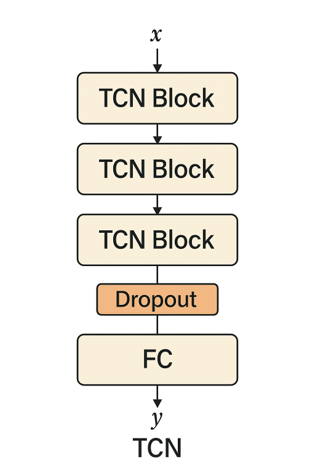

In [ ]:
try:
    import rich, torchmetrics  # noqa
except Exception:
    %pip -q install rich==13.7.1 torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 29.5 MB/s eta 0:00:00


Load data from Google Drive and divide them into 4 subfolders: `full`, `q`, `under`, and `down`.


In [ ]:

'''
## No need to rerun
import os
import re
import shutil

# Set your coordinates directory
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/coordinates"

# Target subfolders
CATEGORIES = ["full", "q", "under", "down"]

# Create subfolders if they don't exist
for cat in CATEGORIES:
    os.makedirs(os.path.join(BASE_DIR, cat), exist_ok=True)

def extract_category(filename: str):
    """
    Get the token after the first '_' and cut at space/underscore/'('.
    Examples:
      ec2022_down (1) edited_SK_coords.npz -> down
      ec2022_under (5)_SK_coords.npz       -> under
      owg2022_q (1)_SK_coords.npz          -> q
      wc2022_full (107)_SK_coords.npz      -> full
    """
    if "_" not in filename:
        return None
    after = filename.split("_", 1)[1]
    token = re.split(r"[ _\(]", after, maxsplit=1)[0]
    token = token.strip().lower()
    return token if token in {"full", "q", "under", "down"} else None

def safe_move(src_path: str, dst_dir: str):
    """
    Move safely; if a file with the same name exists, append _dupX.
    """
    base = os.path.basename(src_path)
    name, ext = os.path.splitext(base)
    dst_path = os.path.join(dst_dir, base)
    if not os.path.exists(dst_path):
        shutil.move(src_path, dst_path)
        return dst_path
    i = 1
    while True:
        candidate = os.path.join(dst_dir, f"{name}_dup{i}{ext}")
        if not os.path.exists(candidate):
            shutil.move(src_path, candidate)
            return candidate
        i += 1

moved, skipped = 0, 0

# Process only files directly under BASE_DIR
for entry in os.listdir(BASE_DIR):
    src = os.path.join(BASE_DIR, entry)
    if not os.path.isfile(src):
        continue
    if not entry.lower().endswith(".npz"):
        continue

    cat = extract_category(entry)
    if cat is None:
        print(f"Skip (unknown category): {entry}")
        skipped += 1
        continue

    dst_dir = os.path.join(BASE_DIR, cat)
    new_path = safe_move(src, dst_dir)
    print(f"Moved -> [{cat}]: {entry} -> {os.path.basename(new_path)}")
    moved += 1

print("\nDone")
print(f"Moved files: {moved}")
print(f"Skipped files: {skipped}")
print(f"Base dir: {BASE_DIR}")
'''

<>:29: SyntaxWarning: invalid escape sequence '\('
<>:29: SyntaxWarning: invalid escape sequence '\('
/tmp/ipython-input-1198859525.py:29: SyntaxWarning: invalid escape sequence '\('
  token = re.split(r"[ _\(]", after, maxsplit=1)[0]


'\n## No need to rerun\nimport os\nimport re\nimport shutil\n\n# Set your coordinates directory\nBASE_DIR = "/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/skeleton_coords_2"\n\n# Target subfolders\nCATEGORIES = ["full", "q", "under", "down"]\n\n# Create subfolders if they don\'t exist\nfor cat in CATEGORIES:\n    os.makedirs(os.path.join(BASE_DIR, cat), exist_ok=True)\n\ndef extract_category(filename: str):\n    """\n    Get the token after the first \'_\' and cut at space/underscore/\'(\'.\n    Examples:\n      ec2022_down (1) edited_SK_coords.npz -> down\n      ec2022_under (5)_SK_coords.npz       -> under\n      owg2022_q (1)_SK_coords.npz          -> q\n      wc2022_full (107)_SK_coords.npz      -> full\n    """\n    if "_" not in filename:\n        return None\n    after = filename.split("_", 1)[1]\n    token = re.split(r"[ _\\(]", after, maxsplit=1)[0]\n    token = token.strip().lower()\n    return token if token in {"full", "q", "under", "down"} else None\n\ndef safe

Emerge q, under and down into 1 class, marked as 1, suggesting there might be a certain degree of under-rotation.

Keep full as 0, suggesting no under-rotation.

In [ ]:
# Repro + imports (put this at the very top of your notebook)
import os, random, numpy as np
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # set before importing torch

random.seed(SEED)
np.random.seed(SEED)

import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

import glob, math, json, time
from typing import Dict, Tuple
from dataclasses import dataclass
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score
from torchmetrics.functional import accuracy
from rich import print

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [ ]:
COORD_DIR = "/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/skeleton_coords_2"

NUM_CLASSES = 2
# MERGE_MAP = { "full": 0, "q": 1, "under": 1, "down": 2 }
MERGE_MAP = { "full": 0, "q": 1, "under": 1, "down": 1 }
T_TARGET = 64
BATCH_SIZE = 32
LR = 1e-3
WEIGHT_DECAY = 1e-2
MAX_EPOCHS = 105
MIN_EPOCHS   = 20
PATIENCE = 50
MIN_DELTA = 1e-3
SMOOTH_K = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In raw pixel space, the same movement can produce widely different coordinate scales depending on the camera's distance, zoom level, or framing. Without normalization, these spatial inconsistencies make it difficult for downstream models to learn meaningful motion patterns, as absolute positions vary across videos even for identical poses.

#### 1. Spatial Normalization
The spatial normalization consists of two steps:

- **Translation normalization**  
  All landmarks are shifted so that the midpoint between the left and right hips lies at the origin. This removes lateral and vertical offsets caused by different camera placements or subject positions.

- **Scale normalization**  
  Coordinates are divided by the **trunk height**, defined as the Euclidean distance between the shoulder midpoint (“neck”) and the mid-hip.  
  
#### 2. Temporal Resampling and Smoothing
To make time series uniform and reduce frame-level noise:

- **Linear resampling**  
  Each channel of the keypoint sequence is linearly interpolated from input length `T_in` to a target length `T_out`, ensuring consistent frame counts across samples.

- **3-frame moving average**  
  A simple smoothing filter is applied independently to each channel to reduce frame-to-frame jitter and produce smoother motion trajectories.


In [ ]:
NOSE = 0
L_SHOULDER, R_SHOULDER = 11, 12
L_HIP, R_HIP = 23, 24

def mid_hip_xy(frame):  # frame: [33,3] (x,y,vis)
    """Mid-hip (x, y)."""
    l = frame[L_HIP]; r = frame[R_HIP]
    return (l[0] + r[0]) / 2.0, (l[1] + r[1]) / 2.0

def trunk_height(frame):
    """Vertical trunk height using shoulder midpoint as neck."""
    ls, rs = frame[L_SHOULDER], frame[R_SHOULDER]
    neck = np.array([(ls[0] + rs[0]) / 2.0, (ls[1] + rs[1]) / 2.0])
    mhx, mhy = mid_hip_xy(frame)
    midhip = np.array([mhx, mhy])
    return np.linalg.norm(neck - midhip) + 1e-8

def linear_resample(arr, T_out):
    """Linear resample arr: [T_in, C] -> [T_out, C]."""
    T_in = arr.shape[0]
    if T_in == T_out:
        return arr
    xs = np.linspace(0, T_in - 1, num=T_in)
    xi = np.linspace(0, T_in - 1, num=T_out)
    out = np.empty((T_out, arr.shape[1]), dtype=arr.dtype)
    for c in range(arr.shape[1]):
        out[:, c] = np.interp(xi, xs, arr[:, c])
    return out

def smooth3(arr):
    """3-frame moving average per channel."""
    if arr.shape[0] < 3:
        return arr
    pad = np.vstack([arr[0:1], arr, arr[-1:]])
    kernel = np.array([1, 1, 1], dtype=np.float32) / 3.0
    out = np.zeros_like(arr)
    for c in range(arr.shape[1]):
        out[:, c] = np.convolve(pad[:, c], kernel, mode="valid")
    return out

Preprocess the skeleton sequences stored as .npz.

For each clip: load [T,33,3] keypoints → take XY, center each frame at mid-hip, scale by the median trunk height (neck–mid-hip) over time.

Smooth with a 3-frame moving average, add first-order differences as velocity. Then stardardize the position and velocity.


In [ ]:
class SimplePoseSeqDataset(Dataset):
    def __init__(self, coord_dir, t_target=64, class_map=None, train=True):
        self.paths = sorted(glob.glob(os.path.join(coord_dir, "*", "*.npz")))
        assert self.paths, f"No npz found under {coord_dir}/*/"
        self.t_target = t_target
        self.train = train
        self.class_map = class_map
        self.samples = []
        for p in self.paths:
            parent = os.path.basename(os.path.dirname(p)).strip().lower()
            if parent not in self.class_map:
                continue
            self.samples.append((p, self.class_map[parent]))
        assert self.samples, "No samples matched your MERGE_MAP under given coord_dir"

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, y = self.samples[idx]
        z = np.load(path, allow_pickle=True)
        kp = z["keypoints"].astype(np.float32)          # [T,33,3]
        xy = kp[:, :, :2]                    # [T,33,2]
        T  = xy.shape[0]

        xy3 = kp
        for t in range(T):
            mx, my = mid_hip_xy(xy3[t])
            xy[t,:,0] -= mx; xy[t,:,1] -= my
        s_seq = np.median([trunk_height(xy3[t]) for t in range(T)]).astype(np.float32)
        xy /= (s_seq + 1e-8)

        seq = xy.reshape(T, -1)
        seq = smooth3(seq)
        vel = np.zeros_like(seq); vel[1:] = seq[1:] - seq[:-1]

        seq = linear_resample(seq, self.t_target)
        vel = linear_resample(vel, self.t_target)
        feat = np.concatenate([seq, vel], axis=1)  # [T,132]

        mean = feat.mean(axis=0, keepdims=True);
        std = feat.std(axis=0, keepdims=True) + 1e-6
        feat = (feat - mean) / std

        x = torch.from_numpy(feat.T).float()       # [C=132, T]
        y = torch.tensor(y).long()
        return x, y

### Temporal Convolutional Network (TCN)
Our project uses a Temporal Convolutional Network (TCN) designed
  specifically for analyzing sequential motion data. The model classifies jumps into rotation quality categories based
  on 2D pose keypoint sequences.
#### Key Features:
  - **Dialation**: Exponentially increasing dilation (1→2→4) captures
   multi-scale temporal patterns
  - **Residual connections**: Enables gradient flow and deeper architectures
  - **Dual pooling**: GAP captures average behavior, GMP captures peak features

  

In [ ]:
# Import TCN model from external module
from tcn_model import TinyTCN, TCNBlock


In [ ]:
# Import training functions from external module
from training import train_one_epoch, evaluate


## 3. Training
We now train the network to classify each motion sequence into its corresponding category.

### 3.1 Training Setup
The TCN model is trained using:

- Optimizer: **Adam**
- Loss function: **Cross-entropy loss**
- Batch size: 32
- Training epochs: until validation performance saturates
- Regularization:
  - Dropout in each TCN block
  - Early stopping based on validation loss

At each epoch, we compute:

- Training loss
- Validation loss
- Accuracy
- Macro F1-score
- Macro recall

This ensures both classification accuracy and class-wise fairness are monitored.


In [ ]:
def set_seed(seed=42):
    import os, random, numpy as np, torch
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
from tcn_model import TinyTCN

full_ds = SimplePoseSeqDataset(COORD_DIR, t_target=T_TARGET, class_map=MERGE_MAP, train=True)
labels = [lab for _, lab in full_ds.samples]

idx_all = np.arange(len(labels))
train_idx, test_idx = train_test_split(idx_all, test_size=0.20, stratify=labels, random_state=42)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.20/0.80,
                                        stratify=np.array(labels)[train_idx], random_state=42)

valid_ds = Subset(SimplePoseSeqDataset(COORD_DIR, t_target=T_TARGET, class_map=MERGE_MAP, train=False), valid_idx)
test_ds  = Subset(SimplePoseSeqDataset(COORD_DIR, t_target=T_TARGET, class_map=MERGE_MAP, train=False),  test_idx)
train_ds = Subset(full_ds, train_idx)

SEED = 42
set_seed(SEED)
g = torch.Generator().manual_seed(SEED)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, generator=g)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True, generator=g)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True, generator=g)

y_train = np.array(labels)[train_idx]
cls_counts = np.bincount(y_train, minlength=NUM_CLASSES)
weights = (cls_counts.sum() / (cls_counts + 1e-6)); weights = weights / weights.mean()
class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)

model = TinyTCN(c_in=132, num_classes=NUM_CLASSES, p_drop=0.2).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)

CKPT_DIR = "./ckpts"
os.makedirs(CKPT_DIR, exist_ok=True)

print("Train set size:", len(train_ds))
print("Valid set size:", len(valid_ds))
print("Test set size :", len(test_ds))


Train set size: 600

Valid set size: 200

Test set size : 200

### 3.2 Hyperparameter Tuning
To efficiently optimize model performance under limited computational budget, we use **Bayesian Optimization** for hyperparameter tuning.

Unlike grid search or random search, Bayesian Optimization builds a probabilistic surrogate model of the objective function and selects hyperparameters by maximizing an acquisition function. This allows the search process to focus on promising regions of the hyperparameter space with significantly fewer evaluations.

The optimization objective is defined as the **validation macro F1-score**, which ensures balanced performance across all four rotation classes.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 18.6 MB/s eta 0:00:00


In [ ]:
# hyperparameter tuning using bayesian optimization
# Note: For F1-based tuning, use create_objective_f1 instead
# This example uses recall-based tuning
study = run_hyperparameter_tuning(objective, n_trials=100, direction="maximize")


[I 2025-11-25 15:45:30,156] A new study created in memory with name: no-name-4d159aa4-7cd1-4c10-9ca9-b91924c386e6


==============================

🔥 Starting Trial 0

Hyperparameters:

lr=0.002285, weight_decay=0.000061, p_drop=0.462

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 0 finished: Best F1=0.7431

[I 2025-11-25 15:52:57,726] Trial 0 finished with value: 0.7431442169675908 and parameters: {'lr': 0.0022845624239087405, 'weight_decay': 6.058464805277188e-05, 'p_drop': 0.4618917000222353, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 0 with value: 0.7431442169675908.


==============================

🔥 Starting Trial 1

Hyperparameters:

lr=0.000117, weight_decay=0.000662, p_drop=0.312

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 1 finished: Best F1=0.6944

[I 2025-11-25 15:54:29,484] Trial 1 finished with value: 0.6943811217715875 and parameters: {'lr': 0.00011691893926877691, 'weight_decay': 0.0006619716939408288, 'p_drop': 0.31238198134247636, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 0 with value: 0.7431442169675908.


==============================

🔥 Starting Trial 2

Hyperparameters:

lr=0.002076, weight_decay=0.000177, p_drop=0.371

hidden_dim=256, kernel_size=3

==============================

🎯 Trial 2 finished: Best F1=0.7834

[I 2025-11-25 15:56:00,756] Trial 2 finished with value: 0.7834353201883608 and parameters: {'lr': 0.0020760915580527364, 'weight_decay': 0.00017714859374907008, 'p_drop': 0.37142264007052245, 'hidden_dim': 256, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 3

Hyperparameters:

lr=0.000029, weight_decay=0.000064, p_drop=0.096

hidden_dim=256, kernel_size=3

==============================

🎯 Trial 3 finished: Best F1=0.6897

[I 2025-11-25 15:57:31,512] Trial 3 finished with value: 0.6897207486738064 and parameters: {'lr': 2.9329342697271338e-05, 'weight_decay': 6.391877588535906e-05, 'p_drop': 0.0963777544758827, 'hidden_dim': 256, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 4

Hyperparameters:

lr=0.000990, weight_decay=0.000033, p_drop=0.031

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 4 finished: Best F1=0.7484

[I 2025-11-25 15:59:03,766] Trial 4 finished with value: 0.748389694041868 and parameters: {'lr': 0.000989733062243294, 'weight_decay': 3.253034245076401e-05, 'p_drop': 0.031455155401518775, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 5

Hyperparameters:

lr=0.000023, weight_decay=0.000049, p_drop=0.190

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 5 finished: Best F1=0.6387

[I 2025-11-25 16:00:35,793] Trial 5 finished with value: 0.6386993175431553 and parameters: {'lr': 2.338487315601302e-05, 'weight_decay': 4.914426534527321e-05, 'p_drop': 0.19002300275404305, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 6

Hyperparameters:

lr=0.003851, weight_decay=0.000003, p_drop=0.261

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 6 finished: Best F1=0.7448

[I 2025-11-25 16:02:06,664] Trial 6 finished with value: 0.7448405253283302 and parameters: {'lr': 0.003850794378947518, 'weight_decay': 2.59935597503472e-06, 'p_drop': 0.2608412101503259, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 7

Hyperparameters:

lr=0.000133, weight_decay=0.000118, p_drop=0.015

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 7 finished: Best F1=0.7278

[I 2025-11-25 16:03:37,909] Trial 7 finished with value: 0.7277951406391774 and parameters: {'lr': 0.00013317519852846342, 'weight_decay': 0.00011847330103688734, 'p_drop': 0.015289654669941477, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 8

Hyperparameters:

lr=0.000115, weight_decay=0.000041, p_drop=0.326

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 8 finished: Best F1=0.6495

[I 2025-11-25 16:05:08,151] Trial 8 finished with value: 0.6495238095238096 and parameters: {'lr': 0.00011506325515686892, 'weight_decay': 4.1443082150454885e-05, 'p_drop': 0.3260579115772892, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 9

Hyperparameters:

lr=0.000020, weight_decay=0.000158, p_drop=0.273

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 9 finished: Best F1=0.5414

[I 2025-11-25 16:06:37,966] Trial 9 finished with value: 0.5414346544382574 and parameters: {'lr': 1.9508130954482386e-05, 'weight_decay': 0.00015787793121939582, 'p_drop': 0.2727640395272509, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 10

Hyperparameters:

lr=0.000503, weight_decay=0.000004, p_drop=0.487

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 10 finished: Best F1=0.6348

[I 2025-11-25 16:08:08,900] Trial 10 finished with value: 0.6348336905612448 and parameters: {'lr': 0.0005033403001274724, 'weight_decay': 4.446405436485784e-06, 'p_drop': 0.4869531032059118, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 11

Hyperparameters:

lr=0.000994, weight_decay=0.000011, p_drop=0.393

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 11 finished: Best F1=0.7300

[I 2025-11-25 16:09:40,576] Trial 11 finished with value: 0.72997299729973 and parameters: {'lr': 0.00099440299024838, 'weight_decay': 1.0576049252686717e-05, 'p_drop': 0.3925841519965097, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 12

Hyperparameters:

lr=0.001166, weight_decay=0.000526, p_drop=0.175

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 12 finished: Best F1=0.7134

[I 2025-11-25 16:11:12,168] Trial 12 finished with value: 0.7133878064110623 and parameters: {'lr': 0.0011659577026518235, 'weight_decay': 0.0005255988588507186, 'p_drop': 0.17484354852516265, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 13

Hyperparameters:

lr=0.000353, weight_decay=0.000015, p_drop=0.009

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 13 finished: Best F1=0.7177

[I 2025-11-25 16:12:42,149] Trial 13 finished with value: 0.7177134791813691 and parameters: {'lr': 0.00035302680466589326, 'weight_decay': 1.4549800717928498e-05, 'p_drop': 0.009162150204381884, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 14

Hyperparameters:

lr=0.001157, weight_decay=0.000216, p_drop=0.395

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 14 finished: Best F1=0.7197

[I 2025-11-25 16:14:12,856] Trial 14 finished with value: 0.7197477729956961 and parameters: {'lr': 0.0011573566247225764, 'weight_decay': 0.000216001350119107, 'p_drop': 0.3954359990068501, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 15

Hyperparameters:

lr=0.004565, weight_decay=0.000001, p_drop=0.112

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 15 finished: Best F1=0.7298

[I 2025-11-25 16:15:43,840] Trial 15 finished with value: 0.7297567811029927 and parameters: {'lr': 0.004565014098194574, 'weight_decay': 1.0787701764319821e-06, 'p_drop': 0.11212043581679007, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 16

Hyperparameters:

lr=0.002035, weight_decay=0.000332, p_drop=0.390

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 16 finished: Best F1=0.7199

[I 2025-11-25 16:17:14,878] Trial 16 finished with value: 0.7198950879784065 and parameters: {'lr': 0.0020345430357403124, 'weight_decay': 0.0003323170265327216, 'p_drop': 0.3904084858230762, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 17

Hyperparameters:

lr=0.000490, weight_decay=0.000017, p_drop=0.089

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 17 finished: Best F1=0.7173

[I 2025-11-25 16:18:45,621] Trial 17 finished with value: 0.7173035902444038 and parameters: {'lr': 0.0004896341533870357, 'weight_decay': 1.691824032182262e-05, 'p_drop': 0.08850923554061485, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 18

Hyperparameters:

lr=0.000258, weight_decay=0.000026, p_drop=0.195

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 18 finished: Best F1=0.7475

[I 2025-11-25 16:20:15,952] Trial 18 finished with value: 0.7474747474747474 and parameters: {'lr': 0.00025840011845134936, 'weight_decay': 2.6321396428684514e-05, 'p_drop': 0.1946818615940362, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 19

Hyperparameters:

lr=0.000739, weight_decay=0.000100, p_drop=0.331

hidden_dim=128, kernel_size=5

==============================

🎯 Trial 19 finished: Best F1=0.7153

[I 2025-11-25 16:21:46,575] Trial 19 finished with value: 0.7152545882840206 and parameters: {'lr': 0.0007391858999202985, 'weight_decay': 9.950382712588237e-05, 'p_drop': 0.33140134113600106, 'hidden_dim': 128, 'kernel_size': 5}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 20

Hyperparameters:

lr=0.002245, weight_decay=0.000007, p_drop=0.435

hidden_dim=256, kernel_size=3

==============================

🎯 Trial 20 finished: Best F1=0.7293

[I 2025-11-25 16:23:15,843] Trial 20 finished with value: 0.7293087157486147 and parameters: {'lr': 0.0022446297626387422, 'weight_decay': 7.050036297278154e-06, 'p_drop': 0.4349759669016256, 'hidden_dim': 256, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 21

Hyperparameters:

lr=0.000050, weight_decay=0.000025, p_drop=0.195

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 21 finished: Best F1=0.6768

[I 2025-11-25 16:24:46,316] Trial 21 finished with value: 0.6767676767676768 and parameters: {'lr': 5.0213510034802636e-05, 'weight_decay': 2.4831936241745758e-05, 'p_drop': 0.19450487730653515, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 22

Hyperparameters:

lr=0.000208, weight_decay=0.000032, p_drop=0.128

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 22 finished: Best F1=0.7649

[I 2025-11-25 16:26:16,673] Trial 22 finished with value: 0.7649471131004475 and parameters: {'lr': 0.00020791954393585012, 'weight_decay': 3.161889730196796e-05, 'p_drop': 0.1279346484629985, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 23

Hyperparameters:

lr=0.000193, weight_decay=0.000974, p_drop=0.053

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 23 finished: Best F1=0.7629

[I 2025-11-25 16:27:45,935] Trial 23 finished with value: 0.7628598097832942 and parameters: {'lr': 0.00019349605563509295, 'weight_decay': 0.0009735003944380742, 'p_drop': 0.05313255503083608, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 24

Hyperparameters:

lr=0.000062, weight_decay=0.000955, p_drop=0.059

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 24 finished: Best F1=0.6900

[I 2025-11-25 16:29:16,384] Trial 24 finished with value: 0.6899689968996899 and parameters: {'lr': 6.23805598442529e-05, 'weight_decay': 0.0009545322543558166, 'p_drop': 0.05949170750357557, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 25

Hyperparameters:

lr=0.000176, weight_decay=0.000333, p_drop=0.153

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 25 finished: Best F1=0.7225

[I 2025-11-25 16:30:46,389] Trial 25 finished with value: 0.7224955220868337 and parameters: {'lr': 0.00017604348852388684, 'weight_decay': 0.0003325193427776597, 'p_drop': 0.15277735073263016, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 26

Hyperparameters:

lr=0.000012, weight_decay=0.000248, p_drop=0.126

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 26 finished: Best F1=0.6300

[I 2025-11-25 16:32:15,606] Trial 26 finished with value: 0.63 and parameters: {'lr': 1.1582758071095469e-05, 'weight_decay': 0.00024780492110973006, 'p_drop': 0.12553767256320528, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 27

Hyperparameters:

lr=0.000083, weight_decay=0.000588, p_drop=0.062

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 27 finished: Best F1=0.7400

[I 2025-11-25 16:33:45,624] Trial 27 finished with value: 0.7399739973997399 and parameters: {'lr': 8.333472022966027e-05, 'weight_decay': 0.0005879405033910204, 'p_drop': 0.061927889506260776, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 28

Hyperparameters:

lr=0.000247, weight_decay=0.000099, p_drop=0.220

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 28 finished: Best F1=0.7576

[I 2025-11-25 16:35:15,914] Trial 28 finished with value: 0.7575757575757576 and parameters: {'lr': 0.00024662077998022594, 'weight_decay': 9.892219587007621e-05, 'p_drop': 0.2200255616444956, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 29

Hyperparameters:

lr=0.000346, weight_decay=0.000990, p_drop=0.148

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 29 finished: Best F1=0.7387

[I 2025-11-25 16:36:45,656] Trial 29 finished with value: 0.7387197266606371 and parameters: {'lr': 0.00034602178186753666, 'weight_decay': 0.0009900397085936923, 'p_drop': 0.1480098667006951, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 30

Hyperparameters:

lr=0.000623, weight_decay=0.000063, p_drop=0.059

hidden_dim=256, kernel_size=3

==============================

🎯 Trial 30 finished: Best F1=0.7339

[I 2025-11-25 16:38:15,970] Trial 30 finished with value: 0.7338756245135698 and parameters: {'lr': 0.0006229519257280511, 'weight_decay': 6.281441569803985e-05, 'p_drop': 0.05856437288448233, 'hidden_dim': 256, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 31

Hyperparameters:

lr=0.000197, weight_decay=0.000092, p_drop=0.211

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 31 finished: Best F1=0.7349

[I 2025-11-25 16:39:46,384] Trial 31 finished with value: 0.7349203461628421 and parameters: {'lr': 0.00019698403239825415, 'weight_decay': 9.177234863727395e-05, 'p_drop': 0.21069515434071506, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 32

Hyperparameters:

lr=0.000307, weight_decay=0.000137, p_drop=0.224

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 32 finished: Best F1=0.7463

[I 2025-11-25 16:41:17,228] Trial 32 finished with value: 0.7463474025974026 and parameters: {'lr': 0.0003065976280978028, 'weight_decay': 0.00013697285134292483, 'p_drop': 0.22390501915862648, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 33

Hyperparameters:

lr=0.000041, weight_decay=0.000064, p_drop=0.289

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 33 finished: Best F1=0.4141

[I 2025-11-25 16:42:47,809] Trial 33 finished with value: 0.41414079121827885 and parameters: {'lr': 4.086285299560795e-05, 'weight_decay': 6.403349676459927e-05, 'p_drop': 0.28874963479076776, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 34

Hyperparameters:

lr=0.000090, weight_decay=0.000189, p_drop=0.226

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 34 finished: Best F1=0.7299

[I 2025-11-25 16:44:19,057] Trial 34 finished with value: 0.7298919567827131 and parameters: {'lr': 8.966434335478788e-05, 'weight_decay': 0.00018927806963320445, 'p_drop': 0.2263248255204584, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 35

Hyperparameters:

lr=0.000152, weight_decay=0.000385, p_drop=0.354

hidden_dim=256, kernel_size=3

==============================

🎯 Trial 35 finished: Best F1=0.7033

[I 2025-11-25 16:45:48,616] Trial 35 finished with value: 0.7033312382149592 and parameters: {'lr': 0.00015178936733784294, 'weight_decay': 0.00038547720241504676, 'p_drop': 0.35381891313030844, 'hidden_dim': 256, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 36

Hyperparameters:

lr=0.001727, weight_decay=0.000042, p_drop=0.239

hidden_dim=128, kernel_size=7

==============================

🎯 Trial 36 finished: Best F1=0.7431

[I 2025-11-25 16:47:19,851] Trial 36 finished with value: 0.7431442169675908 and parameters: {'lr': 0.001727164113414642, 'weight_decay': 4.2065919761307885e-05, 'p_drop': 0.23914299505863457, 'hidden_dim': 128, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 37

Hyperparameters:

lr=0.000218, weight_decay=0.000079, p_drop=0.091

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 37 finished: Best F1=0.7450

[I 2025-11-25 16:48:51,301] Trial 37 finished with value: 0.744993624840621 and parameters: {'lr': 0.00021772673138201318, 'weight_decay': 7.943601867686823e-05, 'p_drop': 0.09061613662322662, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 38

Hyperparameters:

lr=0.000100, weight_decay=0.000032, p_drop=0.147

hidden_dim=256, kernel_size=3

==============================

🎯 Trial 38 finished: Best F1=0.7442

[I 2025-11-25 16:50:22,195] Trial 38 finished with value: 0.7442262845106447 and parameters: {'lr': 9.952761059581387e-05, 'weight_decay': 3.211400848598551e-05, 'p_drop': 0.14727450463364788, 'hidden_dim': 256, 'kernel_size': 3}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 39

Hyperparameters:

lr=0.002883, weight_decay=0.000453, p_drop=0.286

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 39 finished: Best F1=0.7747

[I 2025-11-25 16:51:52,698] Trial 39 finished with value: 0.7747240369452579 and parameters: {'lr': 0.0028831049610967313, 'weight_decay': 0.00045309764223565546, 'p_drop': 0.28587187859979135, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 40

Hyperparameters:

lr=0.003294, weight_decay=0.000515, p_drop=0.359

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 40 finished: Best F1=0.7834

[I 2025-11-25 16:53:22,869] Trial 40 finished with value: 0.7834353201883608 and parameters: {'lr': 0.0032942108653821072, 'weight_decay': 0.0005150970704909283, 'p_drop': 0.3587024960626688, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 41

Hyperparameters:

lr=0.002909, weight_decay=0.000715, p_drop=0.363

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 41 finished: Best F1=0.7450

[I 2025-11-25 16:54:52,927] Trial 41 finished with value: 0.7450020399836801 and parameters: {'lr': 0.002909152604471724, 'weight_decay': 0.0007148212971928169, 'p_drop': 0.3626373474065737, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 42

Hyperparameters:

lr=0.003223, weight_decay=0.000455, p_drop=0.437

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 42 finished: Best F1=0.7559

[I 2025-11-25 16:56:22,750] Trial 42 finished with value: 0.7558742752517547 and parameters: {'lr': 0.003222641217098233, 'weight_decay': 0.0004550325959784867, 'p_drop': 0.43740243306949034, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 43

Hyperparameters:

lr=0.001793, weight_decay=0.000704, p_drop=0.300

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 43 finished: Best F1=0.7523

[I 2025-11-25 16:57:53,305] Trial 43 finished with value: 0.7522687631133245 and parameters: {'lr': 0.0017934852313221854, 'weight_decay': 0.0007044498462248309, 'p_drop': 0.3004526933010973, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 44

Hyperparameters:

lr=0.003289, weight_decay=0.000789, p_drop=0.359

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 44 finished: Best F1=0.7650

[I 2025-11-25 16:59:23,454] Trial 44 finished with value: 0.7649941248531213 and parameters: {'lr': 0.0032894802542661767, 'weight_decay': 0.0007894056342377638, 'p_drop': 0.35894447592960316, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 45

Hyperparameters:

lr=0.004926, weight_decay=0.000275, p_drop=0.352

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 45 finished: Best F1=0.7745

[I 2025-11-25 17:00:53,866] Trial 45 finished with value: 0.7745434504872366 and parameters: {'lr': 0.004926049570407781, 'weight_decay': 0.0002753440678702086, 'p_drop': 0.3515149229900551, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 46

Hyperparameters:

lr=0.004715, weight_decay=0.000295, p_drop=0.346

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 46 finished: Best F1=0.7594

[I 2025-11-25 17:02:23,875] Trial 46 finished with value: 0.7593984962406015 and parameters: {'lr': 0.004714777864833134, 'weight_decay': 0.0002949078851873039, 'p_drop': 0.3461808710653938, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 47

Hyperparameters:

lr=0.002939, weight_decay=0.000494, p_drop=0.274

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 47 finished: Best F1=0.7431

[I 2025-11-25 17:03:53,101] Trial 47 finished with value: 0.7431442169675908 and parameters: {'lr': 0.00293935396292995, 'weight_decay': 0.0004944510786911528, 'p_drop': 0.2737167207146981, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 48

Hyperparameters:

lr=0.001438, weight_decay=0.000174, p_drop=0.375

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 48 finished: Best F1=0.7596

[I 2025-11-25 17:05:24,174] Trial 48 finished with value: 0.7596153846153846 and parameters: {'lr': 0.0014380445444370023, 'weight_decay': 0.0001744365282828033, 'p_drop': 0.37516539300497675, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.7834353201883608.


==============================

🔥 Starting Trial 49

Hyperparameters:

lr=0.003558, weight_decay=0.000257, p_drop=0.416

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 49 finished: Best F1=0.7890

[I 2025-11-25 17:06:55,365] Trial 49 finished with value: 0.7889659330720531 and parameters: {'lr': 0.0035581565489405677, 'weight_decay': 0.0002565969044797415, 'p_drop': 0.41645077020375676, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 50

Hyperparameters:

lr=0.004224, weight_decay=0.000237, p_drop=0.411

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 50 finished: Best F1=0.7332

[I 2025-11-25 17:08:26,357] Trial 50 finished with value: 0.7331691297208538 and parameters: {'lr': 0.004223527369717057, 'weight_decay': 0.00023743852449821225, 'p_drop': 0.41096858999121894, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 51

Hyperparameters:

lr=0.003415, weight_decay=0.000459, p_drop=0.320

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 51 finished: Best F1=0.7398

[I 2025-11-25 17:09:57,573] Trial 51 finished with value: 0.7397657892102892 and parameters: {'lr': 0.00341513880603913, 'weight_decay': 0.0004585574726783535, 'p_drop': 0.32015989019929825, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 52

Hyperparameters:

lr=0.002555, weight_decay=0.000293, p_drop=0.495

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 52 finished: Best F1=0.7633

[I 2025-11-25 17:11:29,345] Trial 52 finished with value: 0.7632897685779759 and parameters: {'lr': 0.0025552721993045853, 'weight_decay': 0.00029260677511057235, 'p_drop': 0.4953552839556948, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 53

Hyperparameters:

lr=0.003763, weight_decay=0.000696, p_drop=0.427

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 53 finished: Best F1=0.7448

[I 2025-11-25 17:12:59,510] Trial 53 finished with value: 0.7448405253283302 and parameters: {'lr': 0.0037631232846549586, 'weight_decay': 0.0006964396723537386, 'p_drop': 0.4266141712751225, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 54

Hyperparameters:

lr=0.001532, weight_decay=0.000127, p_drop=0.451

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 54 finished: Best F1=0.7439

[I 2025-11-25 17:14:28,515] Trial 54 finished with value: 0.7439180537772088 and parameters: {'lr': 0.0015318699957154564, 'weight_decay': 0.00012718169621339106, 'p_drop': 0.4506375204728193, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 55

Hyperparameters:

lr=0.002263, weight_decay=0.000394, p_drop=0.474

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 55 finished: Best F1=0.7786

[I 2025-11-25 17:15:58,278] Trial 55 finished with value: 0.7785829307568438 and parameters: {'lr': 0.0022632311113341343, 'weight_decay': 0.0003940593753639816, 'p_drop': 0.4740096205104078, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 56

Hyperparameters:

lr=0.002314, weight_decay=0.000384, p_drop=0.472

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 56 finished: Best F1=0.7393

[I 2025-11-25 17:17:28,461] Trial 56 finished with value: 0.7393483709273183 and parameters: {'lr': 0.0023138337707684937, 'weight_decay': 0.00038385467960505896, 'p_drop': 0.472397367872635, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 57

Hyperparameters:

lr=0.001200, weight_decay=0.000208, p_drop=0.410

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 57 finished: Best F1=0.7496

[I 2025-11-25 17:18:57,488] Trial 57 finished with value: 0.749599358974359 and parameters: {'lr': 0.0011995514884984052, 'weight_decay': 0.0002076764582775584, 'p_drop': 0.4099866531245583, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 58

Hyperparameters:

lr=0.004901, weight_decay=0.000157, p_drop=0.469

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 58 finished: Best F1=0.7494

[I 2025-11-25 17:20:27,646] Trial 58 finished with value: 0.7493734335839599 and parameters: {'lr': 0.004900791143206345, 'weight_decay': 0.0001567454195106055, 'p_drop': 0.4688636747143645, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 59

Hyperparameters:

lr=0.000808, weight_decay=0.000280, p_drop=0.379

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 59 finished: Best F1=0.7576

[I 2025-11-25 17:21:57,316] Trial 59 finished with value: 0.7575757575757576 and parameters: {'lr': 0.0008077628428455967, 'weight_decay': 0.0002802353325279068, 'p_drop': 0.3793953454345011, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 60

Hyperparameters:

lr=0.001970, weight_decay=0.000419, p_drop=0.338

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 60 finished: Best F1=0.7449

[I 2025-11-25 17:23:26,174] Trial 60 finished with value: 0.7449426120877197 and parameters: {'lr': 0.001969674181123118, 'weight_decay': 0.0004187591402088273, 'p_drop': 0.3380657936483439, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 61

Hyperparameters:

lr=0.002551, weight_decay=0.000730, p_drop=0.314

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 61 finished: Best F1=0.7594

[I 2025-11-25 17:24:55,833] Trial 61 finished with value: 0.7593984962406015 and parameters: {'lr': 0.0025512987021065084, 'weight_decay': 0.0007302036199778221, 'p_drop': 0.3142819591968149, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 62

Hyperparameters:

lr=0.003904, weight_decay=0.000569, p_drop=0.363

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 62 finished: Best F1=0.7383

[I 2025-11-25 17:26:25,922] Trial 62 finished with value: 0.7383252818035426 and parameters: {'lr': 0.003904169498394102, 'weight_decay': 0.0005693617749980882, 'p_drop': 0.36274175214921456, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 63

Hyperparameters:

lr=0.002900, weight_decay=0.000329, p_drop=0.407

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 63 finished: Best F1=0.7442

[I 2025-11-25 17:27:55,210] Trial 63 finished with value: 0.7442262845106447 and parameters: {'lr': 0.0028998886463333226, 'weight_decay': 0.0003288613956396828, 'p_drop': 0.4071082497196114, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 64

Hyperparameters:

lr=0.001432, weight_decay=0.000619, p_drop=0.382

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 64 finished: Best F1=0.7290

[I 2025-11-25 17:29:25,367] Trial 64 finished with value: 0.7290244881573664 and parameters: {'lr': 0.0014320504189212246, 'weight_decay': 0.0006187775327965173, 'p_drop': 0.3822553338081236, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 65

Hyperparameters:

lr=0.003696, weight_decay=0.000876, p_drop=0.456

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 65 finished: Best F1=0.7498

[I 2025-11-25 17:30:55,071] Trial 65 finished with value: 0.7497747973175859 and parameters: {'lr': 0.003696311261794036, 'weight_decay': 0.000876013518452728, 'p_drop': 0.45565326176777415, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 66

Hyperparameters:

lr=0.002110, weight_decay=0.000245, p_drop=0.303

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 66 finished: Best F1=0.7745

[I 2025-11-25 17:32:26,059] Trial 66 finished with value: 0.7745434504872366 and parameters: {'lr': 0.002110337899273868, 'weight_decay': 0.00024462094102150554, 'p_drop': 0.30313567483950155, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 67

Hyperparameters:

lr=0.002119, weight_decay=0.000226, p_drop=0.260

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 67 finished: Best F1=0.7436

[I 2025-11-25 17:33:57,004] Trial 67 finished with value: 0.7435575109993715 and parameters: {'lr': 0.0021190032954213787, 'weight_decay': 0.00022620841438480613, 'p_drop': 0.26031684505034425, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 68

Hyperparameters:

lr=0.000953, weight_decay=0.000152, p_drop=0.298

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 68 finished: Best F1=0.7335

[I 2025-11-25 17:35:28,478] Trial 68 finished with value: 0.7335009428032684 and parameters: {'lr': 0.00095279838899211, 'weight_decay': 0.00015230845151488235, 'p_drop': 0.2977905798234279, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 69

Hyperparameters:

lr=0.002613, weight_decay=0.000356, p_drop=0.280

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 69 finished: Best F1=0.7588

[I 2025-11-25 17:36:58,448] Trial 69 finished with value: 0.7588182092252035 and parameters: {'lr': 0.002612563891116256, 'weight_decay': 0.00035622509784705717, 'p_drop': 0.2802391927366104, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 70

Hyperparameters:

lr=0.004936, weight_decay=0.000003, p_drop=0.327

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 70 finished: Best F1=0.7494

[I 2025-11-25 17:38:28,901] Trial 70 finished with value: 0.7493734335839599 and parameters: {'lr': 0.004936441185768148, 'weight_decay': 2.79764767273609e-06, 'p_drop': 0.3271769274043054, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 71

Hyperparameters:

lr=0.003354, weight_decay=0.000496, p_drop=0.367

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 71 finished: Best F1=0.7600

[I 2025-11-25 17:39:58,715] Trial 71 finished with value: 0.76 and parameters: {'lr': 0.0033542250120089548, 'weight_decay': 0.0004955317771505335, 'p_drop': 0.36696591547065904, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 72

Hyperparameters:

lr=0.002112, weight_decay=0.000263, p_drop=0.399

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 72 finished: Best F1=0.7747

[I 2025-11-25 17:41:28,904] Trial 72 finished with value: 0.7747240369452579 and parameters: {'lr': 0.0021117640091631025, 'weight_decay': 0.0002633092284921717, 'p_drop': 0.39868122934040684, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 73

Hyperparameters:

lr=0.001695, weight_decay=0.000271, p_drop=0.345

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 73 finished: Best F1=0.7598

[I 2025-11-25 17:42:59,080] Trial 73 finished with value: 0.7597838054248824 and parameters: {'lr': 0.0016951795896083762, 'weight_decay': 0.0002709643272300178, 'p_drop': 0.3452277990884322, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 74

Hyperparameters:

lr=0.001306, weight_decay=0.000195, p_drop=0.398

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 74 finished: Best F1=0.7649

[I 2025-11-25 17:44:28,840] Trial 74 finished with value: 0.7648530331457161 and parameters: {'lr': 0.0013055558554193488, 'weight_decay': 0.00019480300151534792, 'p_drop': 0.39812876704011, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 75

Hyperparameters:

lr=0.002070, weight_decay=0.000108, p_drop=0.303

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 75 finished: Best F1=0.7821

[I 2025-11-25 17:45:58,874] Trial 75 finished with value: 0.782118517392516 and parameters: {'lr': 0.0020697009965589992, 'weight_decay': 0.00010765137180233719, 'p_drop': 0.30268885647716576, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 76

Hyperparameters:

lr=0.001057, weight_decay=0.000117, p_drop=0.425

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 76 finished: Best F1=0.7649

[I 2025-11-25 17:47:30,495] Trial 76 finished with value: 0.7649471131004475 and parameters: {'lr': 0.0010571129970822276, 'weight_decay': 0.00011702953764503119, 'p_drop': 0.4254999025532965, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 77

Hyperparameters:

lr=0.004047, weight_decay=0.000080, p_drop=0.249

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 77 finished: Best F1=0.7550

[I 2025-11-25 17:49:01,360] Trial 77 finished with value: 0.7549938748468712 and parameters: {'lr': 0.004046537452316661, 'weight_decay': 8.0318424306722e-05, 'p_drop': 0.2494807968343717, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 78

Hyperparameters:

lr=0.002540, weight_decay=0.000109, p_drop=0.394

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 78 finished: Best F1=0.7695

[I 2025-11-25 17:50:30,843] Trial 78 finished with value: 0.7694613079228464 and parameters: {'lr': 0.0025404858429772534, 'weight_decay': 0.0001089959129289203, 'p_drop': 0.3940034457718922, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 79

Hyperparameters:

lr=0.001896, weight_decay=0.000168, p_drop=0.446

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 79 finished: Best F1=0.7633

[I 2025-11-25 17:52:01,406] Trial 79 finished with value: 0.7632897685779759 and parameters: {'lr': 0.0018960661698442585, 'weight_decay': 0.00016819922341198862, 'p_drop': 0.4461159209903856, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 80

Hyperparameters:

lr=0.002889, weight_decay=0.000399, p_drop=0.333

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 80 finished: Best F1=0.7436

[I 2025-11-25 17:53:32,403] Trial 80 finished with value: 0.7435575109993715 and parameters: {'lr': 0.0028886081628144624, 'weight_decay': 0.00039938778140752, 'p_drop': 0.3334527015267928, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 81

Hyperparameters:

lr=0.002082, weight_decay=0.000231, p_drop=0.308

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 81 finished: Best F1=0.7442

[I 2025-11-25 17:55:01,947] Trial 81 finished with value: 0.7442262845106447 and parameters: {'lr': 0.0020824738151502312, 'weight_decay': 0.00023126044650783264, 'p_drop': 0.3078114251347231, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 49 with value: 0.7889659330720531.


==============================

🔥 Starting Trial 82

Hyperparameters:

lr=0.001621, weight_decay=0.000307, p_drop=0.290

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 82 finished: Best F1=0.7931

[I 2025-11-25 17:56:32,477] Trial 82 finished with value: 0.7931330255556397 and parameters: {'lr': 0.0016209701238676817, 'weight_decay': 0.00030666268037167634, 'p_drop': 0.2903376136461604, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 83

Hyperparameters:

lr=0.001556, weight_decay=0.000330, p_drop=0.263

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 83 finished: Best F1=0.7596

[I 2025-11-25 17:58:04,752] Trial 83 finished with value: 0.7596153846153846 and parameters: {'lr': 0.0015555787200623062, 'weight_decay': 0.0003304663305651902, 'p_drop': 0.26259104701964225, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 84

Hyperparameters:

lr=0.000500, weight_decay=0.000540, p_drop=0.482

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 84 finished: Best F1=0.7374

[I 2025-11-25 17:59:37,485] Trial 84 finished with value: 0.7373737373737375 and parameters: {'lr': 0.0004997034066907855, 'weight_decay': 0.000540082936089027, 'p_drop': 0.4818860749759027, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 85

Hyperparameters:

lr=0.004221, weight_decay=0.000138, p_drop=0.353

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 85 finished: Best F1=0.7400

[I 2025-11-25 18:01:08,545] Trial 85 finished with value: 0.7399739973997399 and parameters: {'lr': 0.00422101521032595, 'weight_decay': 0.00013763002046090876, 'p_drop': 0.35286137001329826, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 86

Hyperparameters:

lr=0.002364, weight_decay=0.000001, p_drop=0.319

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 86 finished: Best F1=0.7247

[I 2025-11-25 18:02:39,851] Trial 86 finished with value: 0.7246627118219819 and parameters: {'lr': 0.0023639278132370684, 'weight_decay': 1.1593475578426787e-06, 'p_drop': 0.3186612785623679, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 87

Hyperparameters:

lr=0.003327, weight_decay=0.000312, p_drop=0.281

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 87 finished: Best F1=0.7548

[I 2025-11-25 18:04:10,988] Trial 87 finished with value: 0.7548467792370231 and parameters: {'lr': 0.0033270722212463627, 'weight_decay': 0.0003121140733880301, 'p_drop': 0.2813326404833476, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 88

Hyperparameters:

lr=0.001792, weight_decay=0.000447, p_drop=0.291

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 88 finished: Best F1=0.7699

[I 2025-11-25 18:05:41,467] Trial 88 finished with value: 0.7699079631852741 and parameters: {'lr': 0.0017921845051500282, 'weight_decay': 0.0004468864866740913, 'p_drop': 0.29091285493653674, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 89

Hyperparameters:

lr=0.002792, weight_decay=0.000267, p_drop=0.420

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 89 finished: Best F1=0.7633

[I 2025-11-25 18:07:13,009] Trial 89 finished with value: 0.7632897685779759 and parameters: {'lr': 0.002791690772899452, 'weight_decay': 0.0002666231656162493, 'p_drop': 0.4201056322316603, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 90

Hyperparameters:

lr=0.000950, weight_decay=0.000189, p_drop=0.378

hidden_dim=128, kernel_size=5

==============================

🎯 Trial 90 finished: Best F1=0.7571

[I 2025-11-25 18:08:43,970] Trial 90 finished with value: 0.7570604312177346 and parameters: {'lr': 0.0009499025757171602, 'weight_decay': 0.0001886617526484975, 'p_drop': 0.37787140472362346, 'hidden_dim': 128, 'kernel_size': 5}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 91

Hyperparameters:

lr=0.001316, weight_decay=0.000227, p_drop=0.308

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 91 finished: Best F1=0.7730

[I 2025-11-25 18:10:14,647] Trial 91 finished with value: 0.7729508817074093 and parameters: {'lr': 0.0013155394693996209, 'weight_decay': 0.0002270072002622032, 'p_drop': 0.30815249525616156, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 92

Hyperparameters:

lr=0.002246, weight_decay=0.000345, p_drop=0.341

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 92 finished: Best F1=0.7694

[I 2025-11-25 18:11:45,241] Trial 92 finished with value: 0.7694235588972431 and parameters: {'lr': 0.0022464818275251875, 'weight_decay': 0.00034549734497935905, 'p_drop': 0.3407666270579019, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 93

Hyperparameters:

lr=0.003152, weight_decay=0.000271, p_drop=0.298

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 93 finished: Best F1=0.7422

[I 2025-11-25 18:13:17,588] Trial 93 finished with value: 0.7421572840567254 and parameters: {'lr': 0.0031518175042493553, 'weight_decay': 0.0002713896497045743, 'p_drop': 0.2976521211787219, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 94

Hyperparameters:

lr=0.002129, weight_decay=0.000386, p_drop=0.238

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 94 finished: Best F1=0.7850

[I 2025-11-25 18:14:48,717] Trial 94 finished with value: 0.7849946248656217 and parameters: {'lr': 0.002128926111955669, 'weight_decay': 0.0003856321065573538, 'p_drop': 0.23847480275446303, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 95

Hyperparameters:

lr=0.004315, weight_decay=0.000601, p_drop=0.243

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 95 finished: Best F1=0.7090

[I 2025-11-25 18:16:18,794] Trial 95 finished with value: 0.7089522280208751 and parameters: {'lr': 0.004314851717467829, 'weight_decay': 0.0006007280228326057, 'p_drop': 0.24250243751702744, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 96

Hyperparameters:

lr=0.003675, weight_decay=0.000413, p_drop=0.213

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 96 finished: Best F1=0.7399

[I 2025-11-25 18:17:50,226] Trial 96 finished with value: 0.7398959583833533 and parameters: {'lr': 0.0036747131007011605, 'weight_decay': 0.00041322634752651087, 'p_drop': 0.21316066017742352, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 97

Hyperparameters:

lr=0.000630, weight_decay=0.000011, p_drop=0.258

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 97 finished: Best F1=0.7416

[I 2025-11-25 18:19:21,864] Trial 97 finished with value: 0.7415824276050771 and parameters: {'lr': 0.0006299746241847233, 'weight_decay': 1.0787320090260072e-05, 'p_drop': 0.25754640900431625, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 98

Hyperparameters:

lr=0.001558, weight_decay=0.000055, p_drop=0.233

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 98 finished: Best F1=0.7749

[I 2025-11-25 18:20:50,387] Trial 98 finished with value: 0.7748592870544091 and parameters: {'lr': 0.0015582762870430037, 'weight_decay': 5.503583884408073e-05, 'p_drop': 0.23298277657379068, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 82 with value: 0.7931330255556397.


==============================

🔥 Starting Trial 99

Hyperparameters:

lr=0.001528, weight_decay=0.000052, p_drop=0.232

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 99 finished: Best F1=0.7447

[I 2025-11-25 18:22:19,966] Trial 99 finished with value: 0.7446872418712923 and parameters: {'lr': 0.0015278749054912462, 'weight_decay': 5.2469664009011196e-05, 'p_drop': 0.23214823518336827, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 82 with value: 0.7931330255556397.


Best Params:
{
    'lr': 0.0016209701238676817,
    'weight_decay': 0.00030666268037167634,
    'p_drop': 0.2903376136461604,
    'hidden_dim': 64,
    'kernel_size': 7
}

Best F1: 0.7931330255556397

In [ ]:
# retrain model using best params - macro f1
'''
Best Params:
{
    'lr': 0.0016209701238676817,
    'weight_decay': 0.00030666268037167634,
    'p_drop': 0.2903376136461604,
    'hidden_dim': 64,
    'kernel_size': 7
}
Best F1: 0.7931330255556397

'''

best_params = {
    'lr': 0.0016209701238676817,
    'weight_decay': 0.00030666268037167634,
    'p_drop': 0.2903376136461604,
    'hidden_dim': 64,
    'kernel_size': 7
}

model = TinyTCN(c_in=132,num_classes= NUM_CLASSES, p_drop=best_params["p_drop"]).to(DEVICE)
# (Only if you modified kernel_size search in objective)
model.block1.conv1.kernel_size = (best_params["kernel_size"],)
model.block2.conv1.kernel_size = (best_params["kernel_size"],)
model.block3.conv1.kernel_size = (best_params["kernel_size"],)

optimizer = torch.optim.AdamW(model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])


In [ ]:
best_score, best_state = -1.0, None
best_epoch = -1
bad = 0
va_hist = []

for epoch in range(1, MAX_EPOCHS + 1):

    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc, va_f1, _, _, va_recall = evaluate(model, valid_loader)

    scheduler.step()

    va_hist.append(va_f1)
    smoothed = np.mean(va_hist[-SMOOTH_K:])

    print(
        f"Epoch {epoch:03d} | "
        f"tr_loss:{tr_loss:.4f} | va_loss:{va_loss:.4f} | "
        f"acc:{va_acc:.4f} | f1:{va_f1:.4f} | "
        f"recall:{va_recall:.4f} | smooth:{smoothed:.4f}"
    )
    # checkpoint
    torch.save(model.state_dict(), f"{CKPT_DIR}/epoch_{epoch:03d}.pt")

    # early stopping
    if epoch >= MIN_EPOCHS:
        if smoothed > best_score + MIN_DELTA:
            best_score = smoothed
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print("Early stop.")
                break
    else:
        if smoothed > best_score:
            best_score = smoothed
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch

print(f"Best epoch (smoothed): {best_epoch}, score={best_score:.4f}")

Epoch 001 | tr_loss:0.6729 | va_loss:0.6126 | acc:0.6900 | f1:0.6892 | recall:0.6900 | smooth:0.6892

Epoch 002 | tr_loss:0.5509 | va_loss:0.6657 | acc:0.6850 | f1:0.6712 | recall:0.6850 | smooth:0.6802

Epoch 003 | tr_loss:0.4485 | va_loss:0.6520 | acc:0.7200 | f1:0.7196 | recall:0.7200 | smooth:0.6933

Epoch 004 | tr_loss:0.4257 | va_loss:0.6372 | acc:0.7200 | f1:0.7177 | recall:0.7200 | smooth:0.7028

Epoch 005 | tr_loss:0.3602 | va_loss:0.6743 | acc:0.7150 | f1:0.7129 | recall:0.7150 | smooth:0.7167

Epoch 006 | tr_loss:0.3434 | va_loss:0.6233 | acc:0.7050 | f1:0.7033 | recall:0.7050 | smooth:0.7113

Epoch 007 | tr_loss:0.2600 | va_loss:1.0445 | acc:0.6950 | f1:0.6941 | recall:0.6950 | smooth:0.7034

Epoch 008 | tr_loss:0.3077 | va_loss:0.7268 | acc:0.7100 | f1:0.7024 | recall:0.7100 | smooth:0.6999

Epoch 009 | tr_loss:0.2361 | va_loss:0.7827 | acc:0.7050 | f1:0.7033 | recall:0.7050 | smooth:0.6999

Epoch 010 | tr_loss:0.1957 | va_loss:1.0011 | acc:0.7250 | f1:0.7206 | recall:0.7250 | smooth:0.7088

Epoch 011 | tr_loss:0.2106 | va_loss:1.0627 | acc:0.6950 | f1:0.6755 | recall:0.6950 | smooth:0.6998

Epoch 012 | tr_loss:0.1680 | va_loss:0.8282 | acc:0.7250 | f1:0.7234 | recall:0.7250 | smooth:0.7065

Epoch 013 | tr_loss:0.1317 | va_loss:1.0152 | acc:0.7350 | f1:0.7345 | recall:0.7350 | smooth:0.7111

Epoch 014 | tr_loss:0.1173 | va_loss:1.8434 | acc:0.6450 | f1:0.6136 | recall:0.6450 | smooth:0.6905

Epoch 015 | tr_loss:0.1220 | va_loss:1.2710 | acc:0.6950 | f1:0.6946 | recall:0.6950 | smooth:0.6809

Epoch 016 | tr_loss:0.1309 | va_loss:1.8721 | acc:0.6450 | f1:0.6112 | recall:0.6450 | smooth:0.6398

Epoch 017 | tr_loss:0.1418 | va_loss:1.2267 | acc:0.6950 | f1:0.6829 | recall:0.6950 | smooth:0.6629

Epoch 018 | tr_loss:0.1185 | va_loss:0.9935 | acc:0.7400 | f1:0.7362 | recall:0.7400 | smooth:0.6768

Epoch 019 | tr_loss:0.0861 | va_loss:1.0658 | acc:0.7050 | f1:0.6945 | recall:0.7050 | smooth:0.7046

Epoch 020 | tr_loss:0.0789 | va_loss:1.0611 | acc:0.7400 | f1:0.7393 | recall:0.7400 | smooth:0.7234

Epoch 021 | tr_loss:0.0947 | va_loss:1.0890 | acc:0.7400 | f1:0.7398 | recall:0.7400 | smooth:0.7246

Epoch 022 | tr_loss:0.0766 | va_loss:1.6616 | acc:0.7100 | f1:0.6966 | recall:0.7100 | smooth:0.7252

Epoch 023 | tr_loss:0.1162 | va_loss:1.0627 | acc:0.7700 | f1:0.7692 | recall:0.7700 | smooth:0.7352

Epoch 024 | tr_loss:0.0506 | va_loss:1.4243 | acc:0.7400 | f1:0.7362 | recall:0.7400 | smooth:0.7340

Epoch 025 | tr_loss:0.0929 | va_loss:1.2025 | acc:0.7600 | f1:0.7600 | recall:0.7600 | smooth:0.7551

Epoch 026 | tr_loss:0.0657 | va_loss:1.1125 | acc:0.7350 | f1:0.7348 | recall:0.7350 | smooth:0.7437

Epoch 027 | tr_loss:0.0896 | va_loss:1.1126 | acc:0.7400 | f1:0.7340 | recall:0.7400 | smooth:0.7429

Epoch 028 | tr_loss:0.0495 | va_loss:1.0441 | acc:0.7450 | f1:0.7447 | recall:0.7450 | smooth:0.7378

Epoch 029 | tr_loss:0.0285 | va_loss:1.0865 | acc:0.7700 | f1:0.7696 | recall:0.7700 | smooth:0.7494

Epoch 030 | tr_loss:0.0765 | va_loss:1.3776 | acc:0.7400 | f1:0.7362 | recall:0.7400 | smooth:0.7502

Epoch 031 | tr_loss:0.0183 | va_loss:1.2513 | acc:0.7500 | f1:0.7488 | recall:0.7500 | smooth:0.7515

Epoch 032 | tr_loss:0.0237 | va_loss:1.4128 | acc:0.7300 | f1:0.7300 | recall:0.7300 | smooth:0.7383

Epoch 033 | tr_loss:0.0515 | va_loss:1.2546 | acc:0.7550 | f1:0.7543 | recall:0.7550 | smooth:0.7443

Epoch 034 | tr_loss:0.0471 | va_loss:1.3423 | acc:0.7550 | f1:0.7517 | recall:0.7550 | smooth:0.7453

Epoch 035 | tr_loss:0.0540 | va_loss:1.4740 | acc:0.7600 | f1:0.7545 | recall:0.7600 | smooth:0.7535

Epoch 036 | tr_loss:0.0532 | va_loss:1.3918 | acc:0.7450 | f1:0.7422 | recall:0.7450 | smooth:0.7494

Epoch 037 | tr_loss:0.0282 | va_loss:1.2147 | acc:0.7650 | f1:0.7629 | recall:0.7650 | smooth:0.7532

Epoch 038 | tr_loss:0.0120 | va_loss:1.5940 | acc:0.7500 | f1:0.7434 | recall:0.7500 | smooth:0.7495

Epoch 039 | tr_loss:0.0547 | va_loss:1.4465 | acc:0.7450 | f1:0.7427 | recall:0.7450 | smooth:0.7497

Epoch 040 | tr_loss:0.0915 | va_loss:1.4229 | acc:0.7750 | f1:0.7750 | recall:0.7750 | smooth:0.7537

Epoch 041 | tr_loss:0.0417 | va_loss:1.1778 | acc:0.7300 | f1:0.7296 | recall:0.7300 | smooth:0.7491

Epoch 042 | tr_loss:0.0387 | va_loss:1.2073 | acc:0.7150 | f1:0.7144 | recall:0.7150 | smooth:0.7397

Epoch 043 | tr_loss:0.0248 | va_loss:1.2974 | acc:0.7750 | f1:0.7737 | recall:0.7750 | smooth:0.7392

Epoch 044 | tr_loss:0.0352 | va_loss:1.3852 | acc:0.7550 | f1:0.7536 | recall:0.7550 | smooth:0.7473

Epoch 045 | tr_loss:0.0379 | va_loss:1.2529 | acc:0.7250 | f1:0.7247 | recall:0.7250 | smooth:0.7507

Epoch 046 | tr_loss:0.0225 | va_loss:1.4103 | acc:0.7400 | f1:0.7391 | recall:0.7400 | smooth:0.7391

Epoch 047 | tr_loss:0.0152 | va_loss:1.4563 | acc:0.7500 | f1:0.7499 | recall:0.7500 | smooth:0.7379

Epoch 048 | tr_loss:0.0134 | va_loss:1.4179 | acc:0.7750 | f1:0.7740 | recall:0.7750 | smooth:0.7543

Epoch 049 | tr_loss:0.0181 | va_loss:1.2570 | acc:0.7700 | f1:0.7694 | recall:0.7700 | smooth:0.7645

Epoch 050 | tr_loss:0.0372 | va_loss:1.3192 | acc:0.7900 | f1:0.7886 | recall:0.7900 | smooth:0.7774

Epoch 051 | tr_loss:0.0127 | va_loss:1.3269 | acc:0.7700 | f1:0.7700 | recall:0.7700 | smooth:0.7760

Epoch 052 | tr_loss:0.0124 | va_loss:1.5467 | acc:0.7500 | f1:0.7463 | recall:0.7500 | smooth:0.7683

Epoch 053 | tr_loss:0.0294 | va_loss:1.6614 | acc:0.7450 | f1:0.7431 | recall:0.7450 | smooth:0.7532

Epoch 054 | tr_loss:0.0343 | va_loss:1.4520 | acc:0.7350 | f1:0.7349 | recall:0.7350 | smooth:0.7415

Epoch 055 | tr_loss:0.0058 | va_loss:1.4428 | acc:0.7450 | f1:0.7427 | recall:0.7450 | smooth:0.7403

Epoch 056 | tr_loss:0.0291 | va_loss:1.7142 | acc:0.7550 | f1:0.7511 | recall:0.7550 | smooth:0.7429

Epoch 057 | tr_loss:0.0217 | va_loss:1.6834 | acc:0.7400 | f1:0.7396 | recall:0.7400 | smooth:0.7445

Epoch 058 | tr_loss:0.0196 | va_loss:1.5768 | acc:0.7650 | f1:0.7643 | recall:0.7650 | smooth:0.7517

Epoch 059 | tr_loss:0.0657 | va_loss:1.2194 | acc:0.7750 | f1:0.7749 | recall:0.7750 | smooth:0.7596

Epoch 060 | tr_loss:0.0257 | va_loss:1.6937 | acc:0.7300 | f1:0.7267 | recall:0.7300 | smooth:0.7553

Epoch 061 | tr_loss:0.0205 | va_loss:1.5395 | acc:0.7800 | f1:0.7786 | recall:0.7800 | smooth:0.7601

Epoch 062 | tr_loss:0.0073 | va_loss:1.7148 | acc:0.7700 | f1:0.7692 | recall:0.7700 | smooth:0.7581

Epoch 063 | tr_loss:0.0207 | va_loss:1.5759 | acc:0.7750 | f1:0.7740 | recall:0.7750 | smooth:0.7739

Epoch 064 | tr_loss:0.0217 | va_loss:1.5275 | acc:0.7850 | f1:0.7843 | recall:0.7850 | smooth:0.7759

Epoch 065 | tr_loss:0.0230 | va_loss:1.8399 | acc:0.7750 | f1:0.7730 | recall:0.7750 | smooth:0.7771

Epoch 066 | tr_loss:0.0467 | va_loss:1.6214 | acc:0.7350 | f1:0.7347 | recall:0.7350 | smooth:0.7640

Epoch 067 | tr_loss:0.0093 | va_loss:1.4536 | acc:0.7400 | f1:0.7400 | recall:0.7400 | smooth:0.7492

Epoch 068 | tr_loss:0.0247 | va_loss:1.5038 | acc:0.7550 | f1:0.7550 | recall:0.7550 | smooth:0.7432

Epoch 069 | tr_loss:0.0099 | va_loss:1.9535 | acc:0.7600 | f1:0.7545 | recall:0.7600 | smooth:0.7498

Epoch 070 | tr_loss:0.0222 | va_loss:1.8591 | acc:0.7500 | f1:0.7480 | recall:0.7500 | smooth:0.7525

Epoch 071 | tr_loss:0.0258 | va_loss:1.7900 | acc:0.7400 | f1:0.7399 | recall:0.7400 | smooth:0.7474

Epoch 072 | tr_loss:0.0550 | va_loss:1.3944 | acc:0.7550 | f1:0.7547 | recall:0.7550 | smooth:0.7475

Epoch 073 | tr_loss:0.0219 | va_loss:1.4333 | acc:0.7350 | f1:0.7348 | recall:0.7350 | smooth:0.7431

Epoch 074 | tr_loss:0.0128 | va_loss:1.4637 | acc:0.7700 | f1:0.7692 | recall:0.7700 | smooth:0.7529

Epoch 075 | tr_loss:0.0275 | va_loss:1.3753 | acc:0.8000 | f1:0.7995 | recall:0.8000 | smooth:0.7678

Epoch 076 | tr_loss:0.0326 | va_loss:1.3143 | acc:0.7850 | f1:0.7838 | recall:0.7850 | smooth:0.7842

Epoch 077 | tr_loss:0.0413 | va_loss:1.1090 | acc:0.7850 | f1:0.7850 | recall:0.7850 | smooth:0.7894

Epoch 078 | tr_loss:0.0306 | va_loss:1.3673 | acc:0.7500 | f1:0.7457 | recall:0.7500 | smooth:0.7715

Epoch 079 | tr_loss:0.0127 | va_loss:1.0478 | acc:0.7550 | f1:0.7550 | recall:0.7550 | smooth:0.7619

Epoch 080 | tr_loss:0.0019 | va_loss:1.1348 | acc:0.7850 | f1:0.7849 | recall:0.7850 | smooth:0.7619

Epoch 081 | tr_loss:0.0133 | va_loss:1.2973 | acc:0.7700 | f1:0.7689 | recall:0.7700 | smooth:0.7696

Epoch 082 | tr_loss:0.0254 | va_loss:1.2995 | acc:0.7750 | f1:0.7749 | recall:0.7750 | smooth:0.7762

Epoch 083 | tr_loss:0.0183 | va_loss:1.0820 | acc:0.7950 | f1:0.7950 | recall:0.7950 | smooth:0.7796

Epoch 084 | tr_loss:0.0164 | va_loss:1.2719 | acc:0.7900 | f1:0.7897 | recall:0.7900 | smooth:0.7865

Epoch 085 | tr_loss:0.0302 | va_loss:1.2924 | acc:0.7850 | f1:0.7847 | recall:0.7850 | smooth:0.7898

Epoch 086 | tr_loss:0.0234 | va_loss:1.3975 | acc:0.7650 | f1:0.7629 | recall:0.7650 | smooth:0.7791

Epoch 087 | tr_loss:0.0161 | va_loss:1.3766 | acc:0.8000 | f1:0.7980 | recall:0.8000 | smooth:0.7819

Epoch 088 | tr_loss:0.0223 | va_loss:1.2693 | acc:0.7800 | f1:0.7800 | recall:0.7800 | smooth:0.7803

Epoch 089 | tr_loss:0.0140 | va_loss:1.3068 | acc:0.7700 | f1:0.7699 | recall:0.7700 | smooth:0.7826

Epoch 090 | tr_loss:0.0143 | va_loss:1.2049 | acc:0.7950 | f1:0.7935 | recall:0.7950 | smooth:0.7811

Epoch 091 | tr_loss:0.0142 | va_loss:1.2945 | acc:0.7950 | f1:0.7947 | recall:0.7950 | smooth:0.7861

Epoch 092 | tr_loss:0.0120 | va_loss:1.7747 | acc:0.7550 | f1:0.7532 | recall:0.7550 | smooth:0.7805

Epoch 093 | tr_loss:0.0208 | va_loss:1.6331 | acc:0.7600 | f1:0.7571 | recall:0.7600 | smooth:0.7683

Epoch 094 | tr_loss:0.0122 | va_loss:1.5741 | acc:0.7650 | f1:0.7649 | recall:0.7650 | smooth:0.7584

Epoch 095 | tr_loss:0.0015 | va_loss:1.6466 | acc:0.7700 | f1:0.7689 | recall:0.7700 | smooth:0.7636

Epoch 096 | tr_loss:0.0233 | va_loss:1.5115 | acc:0.7800 | f1:0.7800 | recall:0.7800 | smooth:0.7712

Epoch 097 | tr_loss:0.0168 | va_loss:1.4617 | acc:0.7800 | f1:0.7800 | recall:0.7800 | smooth:0.7763

Epoch 098 | tr_loss:0.0301 | va_loss:1.7164 | acc:0.7500 | f1:0.7480 | recall:0.7500 | smooth:0.7693

Epoch 099 | tr_loss:0.0071 | va_loss:1.4838 | acc:0.7550 | f1:0.7548 | recall:0.7550 | smooth:0.7609

Epoch 100 | tr_loss:0.0061 | va_loss:1.6478 | acc:0.7550 | f1:0.7550 | recall:0.7550 | smooth:0.7526

Epoch 101 | tr_loss:0.0127 | va_loss:1.7960 | acc:0.7750 | f1:0.7720 | recall:0.7750 | smooth:0.7606

Epoch 102 | tr_loss:0.0075 | va_loss:1.6512 | acc:0.7750 | f1:0.7749 | recall:0.7750 | smooth:0.7673

Epoch 103 | tr_loss:0.0062 | va_loss:1.4880 | acc:0.7700 | f1:0.7696 | recall:0.7700 | smooth:0.7722

Epoch 104 | tr_loss:0.0041 | va_loss:1.7449 | acc:0.7900 | f1:0.7892 | recall:0.7900 | smooth:0.7779

Epoch 105 | tr_loss:0.0149 | va_loss:1.5965 | acc:0.7750 | f1:0.7749 | recall:0.7750 | smooth:0.7779

Best epoch (smoothed): 77, score=0.7894

### Using Macro Recall


In [ ]:
# Import hyperparameter tuning functions from external module
from hyperparameter_tuning import create_objective_recall, run_hyperparameter_tuning

In [ ]:
## Using recall - Create objective function using imported module
objective = create_objective_recall(
    model_class=TinyTCN,
    c_in=132,
    num_classes=NUM_CLASSES,
    device=DEVICE,
    train_loader=train_loader,
    valid_loader=valid_loader,
    class_weights=class_weights,
    train_one_epoch=train_one_epoch,
    evaluate=evaluate,
    max_epochs=15
)


In [ ]:
# hyperparameter tuning using bayesian optimization
study = run_hyperparameter_tuning(objective, n_trials=100, direction="maximize")
# macro recall
# Best Params and Best Value are already printed by run_hyperparameter_tuning

[I 2025-11-26 22:57:55,045] A new study created in memory with name: no-name-8c34a8c1-b176-4bde-9a21-40a9f9ec60a3


==============================

🔥 Starting Trial 0

Hyperparameters:

lr=0.000019, weight_decay=0.000040, p_drop=0.468

hidden_dim=128, kernel_size=5

==============================

🎯 Trial 0 finished: Best Recall=0.5350

[I 2025-11-26 23:07:08,540] Trial 0 finished with value: 0.535 and parameters: {'lr': 1.8860071468654744e-05, 'weight_decay': 3.9884008025459854e-05, 'p_drop': 0.468446940944505, 'hidden_dim': 128, 'kernel_size': 5}. Best is trial 0 with value: 0.535.


==============================

🔥 Starting Trial 1

Hyperparameters:

lr=0.000143, weight_decay=0.000089, p_drop=0.243

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 1 finished: Best Recall=0.7300

[I 2025-11-26 23:08:46,024] Trial 1 finished with value: 0.73 and parameters: {'lr': 0.00014290933541805784, 'weight_decay': 8.933798374222909e-05, 'p_drop': 0.2429993161592991, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 1 with value: 0.73.


==============================

🔥 Starting Trial 2

Hyperparameters:

lr=0.000117, weight_decay=0.000511, p_drop=0.196

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 2 finished: Best Recall=0.7100

[I 2025-11-26 23:10:25,357] Trial 2 finished with value: 0.71 and parameters: {'lr': 0.00011731482405861766, 'weight_decay': 0.0005112785670507166, 'p_drop': 0.19558131595919792, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 1 with value: 0.73.


==============================

🔥 Starting Trial 3

Hyperparameters:

lr=0.000606, weight_decay=0.000789, p_drop=0.125

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 3 finished: Best Recall=0.7550

[I 2025-11-26 23:12:02,404] Trial 3 finished with value: 0.755 and parameters: {'lr': 0.000606236247476482, 'weight_decay': 0.0007894542709090039, 'p_drop': 0.12480120250646248, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 3 with value: 0.755.


==============================

🔥 Starting Trial 4

Hyperparameters:

lr=0.000411, weight_decay=0.000183, p_drop=0.433

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 4 finished: Best Recall=0.7100

[I 2025-11-26 23:13:40,268] Trial 4 finished with value: 0.71 and parameters: {'lr': 0.0004112329807521188, 'weight_decay': 0.00018299263621502122, 'p_drop': 0.4327646345793222, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 3 with value: 0.755.


==============================

🔥 Starting Trial 5

Hyperparameters:

lr=0.000620, weight_decay=0.000036, p_drop=0.412

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 5 finished: Best Recall=0.7400

[I 2025-11-26 23:15:17,625] Trial 5 finished with value: 0.74 and parameters: {'lr': 0.0006204485326710971, 'weight_decay': 3.610024857262505e-05, 'p_drop': 0.41175385572629847, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 3 with value: 0.755.


==============================

🔥 Starting Trial 6

Hyperparameters:

lr=0.000414, weight_decay=0.000032, p_drop=0.029

hidden_dim=256, kernel_size=3

==============================

🎯 Trial 6 finished: Best Recall=0.7300

[I 2025-11-26 23:16:55,846] Trial 6 finished with value: 0.73 and parameters: {'lr': 0.0004141247894215558, 'weight_decay': 3.178318248674037e-05, 'p_drop': 0.028579590953871914, 'hidden_dim': 256, 'kernel_size': 3}. Best is trial 3 with value: 0.755.


==============================

🔥 Starting Trial 7

Hyperparameters:

lr=0.000011, weight_decay=0.000077, p_drop=0.256

hidden_dim=128, kernel_size=7

==============================

🎯 Trial 7 finished: Best Recall=0.5350

[I 2025-11-26 23:18:32,832] Trial 7 finished with value: 0.535 and parameters: {'lr': 1.1235422160321183e-05, 'weight_decay': 7.695825539196278e-05, 'p_drop': 0.25617580770739945, 'hidden_dim': 128, 'kernel_size': 7}. Best is trial 3 with value: 0.755.


==============================

🔥 Starting Trial 8

Hyperparameters:

lr=0.000145, weight_decay=0.000018, p_drop=0.040

hidden_dim=256, kernel_size=7

==============================

🎯 Trial 8 finished: Best Recall=0.7350

[I 2025-11-26 23:20:10,527] Trial 8 finished with value: 0.735 and parameters: {'lr': 0.0001447131851211216, 'weight_decay': 1.8179449015395374e-05, 'p_drop': 0.03981031409457353, 'hidden_dim': 256, 'kernel_size': 7}. Best is trial 3 with value: 0.755.


==============================

🔥 Starting Trial 9

Hyperparameters:

lr=0.000060, weight_decay=0.000002, p_drop=0.482

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 9 finished: Best Recall=0.5950

[I 2025-11-26 23:21:46,946] Trial 9 finished with value: 0.595 and parameters: {'lr': 6.0085244958898616e-05, 'weight_decay': 2.142470254267007e-06, 'p_drop': 0.4817543395391169, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 3 with value: 0.755.


==============================

🔥 Starting Trial 10

Hyperparameters:

lr=0.004053, weight_decay=0.000840, p_drop=0.121

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 10 finished: Best Recall=0.7650

[I 2025-11-26 23:23:23,419] Trial 10 finished with value: 0.765 and parameters: {'lr': 0.0040530619199285545, 'weight_decay': 0.000839802977068065, 'p_drop': 0.12071223843006187, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 10 with value: 0.765.


==============================

🔥 Starting Trial 11

Hyperparameters:

lr=0.004863, weight_decay=0.000906, p_drop=0.135

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 11 finished: Best Recall=0.7400

[I 2025-11-26 23:25:01,293] Trial 11 finished with value: 0.74 and parameters: {'lr': 0.004862771288404342, 'weight_decay': 0.0009056238081179497, 'p_drop': 0.1352326185589324, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 10 with value: 0.765.


==============================

🔥 Starting Trial 12

Hyperparameters:

lr=0.003579, weight_decay=0.000343, p_drop=0.122

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 12 finished: Best Recall=0.7700

[I 2025-11-26 23:26:37,997] Trial 12 finished with value: 0.77 and parameters: {'lr': 0.003578976020809373, 'weight_decay': 0.0003427723455276241, 'p_drop': 0.12211656670050368, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 12 with value: 0.77.


==============================

🔥 Starting Trial 13

Hyperparameters:

lr=0.004784, weight_decay=0.000252, p_drop=0.108

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 13 finished: Best Recall=0.7800

[I 2025-11-26 23:28:14,624] Trial 13 finished with value: 0.78 and parameters: {'lr': 0.004784268132819802, 'weight_decay': 0.0002522864939006916, 'p_drop': 0.10847789371299933, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 14

Hyperparameters:

lr=0.001906, weight_decay=0.000242, p_drop=0.328

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 14 finished: Best Recall=0.7350

[I 2025-11-26 23:29:50,654] Trial 14 finished with value: 0.735 and parameters: {'lr': 0.0019064245289242246, 'weight_decay': 0.000242448262983862, 'p_drop': 0.3283687550338211, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 15

Hyperparameters:

lr=0.001544, weight_decay=0.000007, p_drop=0.073

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 15 finished: Best Recall=0.7600

[I 2025-11-26 23:31:28,047] Trial 15 finished with value: 0.76 and parameters: {'lr': 0.0015437219790237627, 'weight_decay': 6.882780880355495e-06, 'p_drop': 0.07332771334049404, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 16

Hyperparameters:

lr=0.001573, weight_decay=0.000263, p_drop=0.188

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 16 finished: Best Recall=0.7500

[I 2025-11-26 23:33:04,757] Trial 16 finished with value: 0.75 and parameters: {'lr': 0.0015734196086948868, 'weight_decay': 0.0002625076732904034, 'p_drop': 0.1880536832708749, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 17

Hyperparameters:

lr=0.002495, weight_decay=0.000121, p_drop=0.008

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 17 finished: Best Recall=0.7700

[I 2025-11-26 23:34:43,167] Trial 17 finished with value: 0.77 and parameters: {'lr': 0.0024946266687659656, 'weight_decay': 0.000120585429743833, 'p_drop': 0.008349590385894223, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 18

Hyperparameters:

lr=0.000805, weight_decay=0.000334, p_drop=0.088

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 18 finished: Best Recall=0.7450

[I 2025-11-26 23:36:19,928] Trial 18 finished with value: 0.745 and parameters: {'lr': 0.0008047116905593358, 'weight_decay': 0.00033362603088557584, 'p_drop': 0.08757752022399082, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 19

Hyperparameters:

lr=0.002794, weight_decay=0.000009, p_drop=0.181

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 19 finished: Best Recall=0.7600

[I 2025-11-26 23:37:56,562] Trial 19 finished with value: 0.76 and parameters: {'lr': 0.002793670229700919, 'weight_decay': 9.054193480700177e-06, 'p_drop': 0.18144808375155944, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 20

Hyperparameters:

lr=0.001095, weight_decay=0.000406, p_drop=0.310

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 20 finished: Best Recall=0.7400

[I 2025-11-26 23:39:34,616] Trial 20 finished with value: 0.74 and parameters: {'lr': 0.0010945600487822643, 'weight_decay': 0.00040620350761387064, 'p_drop': 0.30995565685239057, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 21

Hyperparameters:

lr=0.002743, weight_decay=0.000107, p_drop=0.019

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 21 finished: Best Recall=0.7450

[I 2025-11-26 23:41:11,287] Trial 21 finished with value: 0.745 and parameters: {'lr': 0.0027431219380354838, 'weight_decay': 0.00010675438014452366, 'p_drop': 0.019131881323652636, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 22

Hyperparameters:

lr=0.004914, weight_decay=0.000068, p_drop=0.002

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 22 finished: Best Recall=0.7250

[I 2025-11-26 23:42:48,859] Trial 22 finished with value: 0.7250000000000001 and parameters: {'lr': 0.00491353553294723, 'weight_decay': 6.806956098686304e-05, 'p_drop': 0.002103089468320954, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 23

Hyperparameters:

lr=0.002402, weight_decay=0.000144, p_drop=0.068

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 23 finished: Best Recall=0.7350

[I 2025-11-26 23:44:25,550] Trial 23 finished with value: 0.7350000000000001 and parameters: {'lr': 0.0024017887545742375, 'weight_decay': 0.00014400493706848204, 'p_drop': 0.06849223237453433, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 24

Hyperparameters:

lr=0.001121, weight_decay=0.000180, p_drop=0.094

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 24 finished: Best Recall=0.7600

[I 2025-11-26 23:46:03,905] Trial 24 finished with value: 0.76 and parameters: {'lr': 0.0011212109902815864, 'weight_decay': 0.00018033657603318333, 'p_drop': 0.09378162108853941, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 25

Hyperparameters:

lr=0.003095, weight_decay=0.000469, p_drop=0.168

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 25 finished: Best Recall=0.7600

[I 2025-11-26 23:47:40,395] Trial 25 finished with value: 0.76 and parameters: {'lr': 0.0030949491530670266, 'weight_decay': 0.0004686033872072834, 'p_drop': 0.16824790387253014, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 26

Hyperparameters:

lr=0.000314, weight_decay=0.000131, p_drop=0.061

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 26 finished: Best Recall=0.7500

[I 2025-11-26 23:49:18,500] Trial 26 finished with value: 0.75 and parameters: {'lr': 0.00031437303472198923, 'weight_decay': 0.00013149306860468535, 'p_drop': 0.06073702818083444, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 27

Hyperparameters:

lr=0.001216, weight_decay=0.000047, p_drop=0.142

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 27 finished: Best Recall=0.7450

[I 2025-11-26 23:50:54,946] Trial 27 finished with value: 0.745 and parameters: {'lr': 0.0012164546287534398, 'weight_decay': 4.687267495456548e-05, 'p_drop': 0.14237222131400912, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 28

Hyperparameters:

lr=0.003379, weight_decay=0.000018, p_drop=0.247

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 28 finished: Best Recall=0.7550

[I 2025-11-26 23:52:31,942] Trial 28 finished with value: 0.755 and parameters: {'lr': 0.0033793258171334758, 'weight_decay': 1.7763432806257263e-05, 'p_drop': 0.24735535351188465, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 29

Hyperparameters:

lr=0.000059, weight_decay=0.000055, p_drop=0.046

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 29 finished: Best Recall=0.6850

[I 2025-11-26 23:54:09,310] Trial 29 finished with value: 0.685 and parameters: {'lr': 5.914442913697629e-05, 'weight_decay': 5.5172350879646125e-05, 'p_drop': 0.046083771304853485, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 30

Hyperparameters:

lr=0.002051, weight_decay=0.000562, p_drop=0.100

hidden_dim=128, kernel_size=7

==============================

🎯 Trial 30 finished: Best Recall=0.7400

[I 2025-11-26 23:55:45,113] Trial 30 finished with value: 0.74 and parameters: {'lr': 0.0020512835988418985, 'weight_decay': 0.0005624600537776537, 'p_drop': 0.10022268795816819, 'hidden_dim': 128, 'kernel_size': 7}. Best is trial 13 with value: 0.78.


==============================

🔥 Starting Trial 31

Hyperparameters:

lr=0.004024, weight_decay=0.000942, p_drop=0.117

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 31 finished: Best Recall=0.8050

[I 2025-11-26 23:57:23,322] Trial 31 finished with value: 0.8049999999999999 and parameters: {'lr': 0.004024065957073819, 'weight_decay': 0.0009420907687749839, 'p_drop': 0.11719952929713866, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 32

Hyperparameters:

lr=0.004783, weight_decay=0.000250, p_drop=0.223

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 32 finished: Best Recall=0.7600

[I 2025-11-26 23:59:00,066] Trial 32 finished with value: 0.76 and parameters: {'lr': 0.004782589532281043, 'weight_decay': 0.0002501000728747525, 'p_drop': 0.22292713667441122, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 33

Hyperparameters:

lr=0.003244, weight_decay=0.000502, p_drop=0.164

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 33 finished: Best Recall=0.7450

[I 2025-11-27 00:00:37,918] Trial 33 finished with value: 0.745 and parameters: {'lr': 0.003243988145659238, 'weight_decay': 0.0005019089457360362, 'p_drop': 0.16443794295315334, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 34

Hyperparameters:

lr=0.001821, weight_decay=0.000668, p_drop=0.294

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 34 finished: Best Recall=0.7500

[I 2025-11-27 00:02:14,583] Trial 34 finished with value: 0.75 and parameters: {'lr': 0.0018212066773391539, 'weight_decay': 0.0006683287649362586, 'p_drop': 0.29365340333181494, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 35

Hyperparameters:

lr=0.000858, weight_decay=0.000337, p_drop=0.212

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 35 finished: Best Recall=0.7150

[I 2025-11-27 00:03:51,772] Trial 35 finished with value: 0.7150000000000001 and parameters: {'lr': 0.0008583089804211392, 'weight_decay': 0.00033683260090820185, 'p_drop': 0.21193967544140946, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 36

Hyperparameters:

lr=0.002613, weight_decay=0.000995, p_drop=0.115

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 36 finished: Best Recall=0.7700

[I 2025-11-27 00:05:26,197] Trial 36 finished with value: 0.77 and parameters: {'lr': 0.0026126790470007042, 'weight_decay': 0.000994634365848966, 'p_drop': 0.11518271698440702, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 37

Hyperparameters:

lr=0.003890, weight_decay=0.000001, p_drop=0.149

hidden_dim=128, kernel_size=3

==============================

🎯 Trial 37 finished: Best Recall=0.7550

[I 2025-11-27 00:07:02,991] Trial 37 finished with value: 0.755 and parameters: {'lr': 0.0038897496105502927, 'weight_decay': 1.050168009249799e-06, 'p_drop': 0.14913696394042614, 'hidden_dim': 128, 'kernel_size': 3}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 38

Hyperparameters:

lr=0.000039, weight_decay=0.000187, p_drop=0.357

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 38 finished: Best Recall=0.6200

[I 2025-11-27 00:08:40,092] Trial 38 finished with value: 0.62 and parameters: {'lr': 3.910674901785991e-05, 'weight_decay': 0.00018735156307129468, 'p_drop': 0.35691713829893723, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 39

Hyperparameters:

lr=0.000644, weight_decay=0.000127, p_drop=0.002

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 39 finished: Best Recall=0.7500

[I 2025-11-27 00:10:15,753] Trial 39 finished with value: 0.75 and parameters: {'lr': 0.0006435487736012487, 'weight_decay': 0.00012741479252572897, 'p_drop': 0.0016472769419586253, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 40

Hyperparameters:

lr=0.000199, weight_decay=0.000643, p_drop=0.056

hidden_dim=128, kernel_size=5

==============================

🎯 Trial 40 finished: Best Recall=0.7600

[I 2025-11-27 00:11:52,920] Trial 40 finished with value: 0.76 and parameters: {'lr': 0.00019929299419197872, 'weight_decay': 0.0006425134643346604, 'p_drop': 0.05562016771496241, 'hidden_dim': 128, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 41

Hyperparameters:

lr=0.002360, weight_decay=0.000933, p_drop=0.113

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 41 finished: Best Recall=0.7900

[I 2025-11-27 00:13:29,014] Trial 41 finished with value: 0.79 and parameters: {'lr': 0.0023595017221504696, 'weight_decay': 0.0009325926515960089, 'p_drop': 0.11299892725236554, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 42

Hyperparameters:

lr=0.001462, weight_decay=0.000347, p_drop=0.103

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 42 finished: Best Recall=0.7900

[I 2025-11-27 00:15:06,751] Trial 42 finished with value: 0.79 and parameters: {'lr': 0.0014617016309412807, 'weight_decay': 0.0003473641360804249, 'p_drop': 0.10343220911027268, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 43

Hyperparameters:

lr=0.001426, weight_decay=0.000374, p_drop=0.116

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 43 finished: Best Recall=0.7200

[I 2025-11-27 00:16:42,820] Trial 43 finished with value: 0.72 and parameters: {'lr': 0.0014262891805299884, 'weight_decay': 0.0003735380256532913, 'p_drop': 0.11559359041661456, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 44

Hyperparameters:

lr=0.003686, weight_decay=0.000723, p_drop=0.152

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 44 finished: Best Recall=0.7500

[I 2025-11-27 00:18:19,578] Trial 44 finished with value: 0.75 and parameters: {'lr': 0.003685966458985803, 'weight_decay': 0.0007229671189943484, 'p_drop': 0.15238260078760257, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 45

Hyperparameters:

lr=0.004889, weight_decay=0.000537, p_drop=0.087

hidden_dim=256, kernel_size=3

==============================

🎯 Trial 45 finished: Best Recall=0.7450

[I 2025-11-27 00:19:56,577] Trial 45 finished with value: 0.745 and parameters: {'lr': 0.004888867273655276, 'weight_decay': 0.0005372013719641379, 'p_drop': 0.08685871034019432, 'hidden_dim': 256, 'kernel_size': 3}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 46

Hyperparameters:

lr=0.000427, weight_decay=0.000281, p_drop=0.129

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 46 finished: Best Recall=0.7500

[I 2025-11-27 00:21:32,500] Trial 46 finished with value: 0.75 and parameters: {'lr': 0.00042723651406906835, 'weight_decay': 0.00028123402686881576, 'p_drop': 0.12858309362657278, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 47

Hyperparameters:

lr=0.002309, weight_decay=0.000197, p_drop=0.205

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 47 finished: Best Recall=0.7600

[I 2025-11-27 00:23:09,888] Trial 47 finished with value: 0.76 and parameters: {'lr': 0.0023094724965607998, 'weight_decay': 0.00019700816052323507, 'p_drop': 0.20525097539709247, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 48

Hyperparameters:

lr=0.001820, weight_decay=0.000958, p_drop=0.110

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 48 finished: Best Recall=0.7900

[I 2025-11-27 00:24:46,144] Trial 48 finished with value: 0.79 and parameters: {'lr': 0.0018199604039949215, 'weight_decay': 0.0009582401986082879, 'p_drop': 0.11031462443265622, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 49

Hyperparameters:

lr=0.000871, weight_decay=0.000880, p_drop=0.446

hidden_dim=128, kernel_size=5

==============================

🎯 Trial 49 finished: Best Recall=0.7350

[I 2025-11-27 00:26:23,286] Trial 49 finished with value: 0.735 and parameters: {'lr': 0.000871384184366319, 'weight_decay': 0.0008795239266233959, 'p_drop': 0.44570368508561165, 'hidden_dim': 128, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 50

Hyperparameters:

lr=0.001929, weight_decay=0.000988, p_drop=0.108

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 50 finished: Best Recall=0.7500

[I 2025-11-27 00:28:00,436] Trial 50 finished with value: 0.75 and parameters: {'lr': 0.0019294344346561234, 'weight_decay': 0.000987930631099122, 'p_drop': 0.10846857210698702, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 51

Hyperparameters:

lr=0.001493, weight_decay=0.000670, p_drop=0.033

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 51 finished: Best Recall=0.7500

[I 2025-11-27 00:29:36,530] Trial 51 finished with value: 0.75 and parameters: {'lr': 0.0014933391836823508, 'weight_decay': 0.0006697363941672157, 'p_drop': 0.03317716279549014, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 52

Hyperparameters:

lr=0.003853, weight_decay=0.000388, p_drop=0.079

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 52 finished: Best Recall=0.7650

[I 2025-11-27 00:31:13,587] Trial 52 finished with value: 0.7649999999999999 and parameters: {'lr': 0.0038530206358239755, 'weight_decay': 0.00038779806594270444, 'p_drop': 0.0794901984564942, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 53

Hyperparameters:

lr=0.001905, weight_decay=0.000469, p_drop=0.132

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 53 finished: Best Recall=0.7600

[I 2025-11-27 00:32:50,217] Trial 53 finished with value: 0.76 and parameters: {'lr': 0.0019050494996805576, 'weight_decay': 0.0004694742851972987, 'p_drop': 0.13231902562826459, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 54

Hyperparameters:

lr=0.003189, weight_decay=0.000690, p_drop=0.184

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 54 finished: Best Recall=0.7650

[I 2025-11-27 00:34:28,351] Trial 54 finished with value: 0.765 and parameters: {'lr': 0.003188918081234898, 'weight_decay': 0.0006903952040244987, 'p_drop': 0.1842709735763584, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 55

Hyperparameters:

lr=0.002399, weight_decay=0.000305, p_drop=0.167

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 55 finished: Best Recall=0.7450

[I 2025-11-27 00:36:04,571] Trial 55 finished with value: 0.745 and parameters: {'lr': 0.002398809621560387, 'weight_decay': 0.0003045132329851053, 'p_drop': 0.1671713536188353, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 56

Hyperparameters:

lr=0.000019, weight_decay=0.000221, p_drop=0.101

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 56 finished: Best Recall=0.6150

[I 2025-11-27 00:37:39,900] Trial 56 finished with value: 0.615 and parameters: {'lr': 1.893546704661944e-05, 'weight_decay': 0.00022109618057026572, 'p_drop': 0.10142085640114894, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 57

Hyperparameters:

lr=0.001023, weight_decay=0.000437, p_drop=0.074

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 57 finished: Best Recall=0.7450

[I 2025-11-27 00:39:17,271] Trial 57 finished with value: 0.745 and parameters: {'lr': 0.0010227572393200937, 'weight_decay': 0.0004374370668445808, 'p_drop': 0.07397994183444503, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 58

Hyperparameters:

lr=0.001325, weight_decay=0.000023, p_drop=0.133

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 58 finished: Best Recall=0.7550

[I 2025-11-27 00:40:53,875] Trial 58 finished with value: 0.755 and parameters: {'lr': 0.0013249238217255782, 'weight_decay': 2.3268196125714768e-05, 'p_drop': 0.13310747530276934, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 59

Hyperparameters:

lr=0.004150, weight_decay=0.000771, p_drop=0.041

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 59 finished: Best Recall=0.7350

[I 2025-11-27 00:42:32,025] Trial 59 finished with value: 0.7350000000000001 and parameters: {'lr': 0.004149893434073333, 'weight_decay': 0.0007711904974766549, 'p_drop': 0.04127226397346198, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 60

Hyperparameters:

lr=0.000586, weight_decay=0.000547, p_drop=0.268

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 60 finished: Best Recall=0.7450

[I 2025-11-27 00:44:08,809] Trial 60 finished with value: 0.745 and parameters: {'lr': 0.000585555872508278, 'weight_decay': 0.0005470111776860161, 'p_drop': 0.26827526423474746, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 61

Hyperparameters:

lr=0.002521, weight_decay=0.000350, p_drop=0.065

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 61 finished: Best Recall=0.7750

[I 2025-11-27 00:45:44,599] Trial 61 finished with value: 0.775 and parameters: {'lr': 0.002520852371870263, 'weight_decay': 0.0003500261279965412, 'p_drop': 0.06496622156676575, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 62

Hyperparameters:

lr=0.001673, weight_decay=0.000085, p_drop=0.057

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 62 finished: Best Recall=0.7550

[I 2025-11-27 00:47:21,456] Trial 62 finished with value: 0.755 and parameters: {'lr': 0.0016725985929774234, 'weight_decay': 8.498302306657203e-05, 'p_drop': 0.0571096272501394, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 63

Hyperparameters:

lr=0.002525, weight_decay=0.000168, p_drop=0.022

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 63 finished: Best Recall=0.7450

[I 2025-11-27 00:48:57,589] Trial 63 finished with value: 0.745 and parameters: {'lr': 0.002525428998829277, 'weight_decay': 0.0001676966725535067, 'p_drop': 0.02208795809643494, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 64

Hyperparameters:

lr=0.003019, weight_decay=0.000323, p_drop=0.096

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 64 finished: Best Recall=0.7650

[I 2025-11-27 00:50:35,930] Trial 64 finished with value: 0.765 and parameters: {'lr': 0.0030189344586913427, 'weight_decay': 0.00032265465656686177, 'p_drop': 0.09566043213786052, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 65

Hyperparameters:

lr=0.002052, weight_decay=0.000868, p_drop=0.150

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 65 finished: Best Recall=0.7650

[I 2025-11-27 00:52:11,944] Trial 65 finished with value: 0.765 and parameters: {'lr': 0.002051680621997767, 'weight_decay': 0.0008676978549153676, 'p_drop': 0.150039045795339, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 66

Hyperparameters:

lr=0.003962, weight_decay=0.000005, p_drop=0.081

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 66 finished: Best Recall=0.7500

[I 2025-11-27 00:53:48,147] Trial 66 finished with value: 0.75 and parameters: {'lr': 0.0039618310914807985, 'weight_decay': 5.120199543323651e-06, 'p_drop': 0.08094362301292636, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 67

Hyperparameters:

lr=0.003154, weight_decay=0.000104, p_drop=0.115

hidden_dim=64, kernel_size=7

==============================

🎯 Trial 67 finished: Best Recall=0.7250

[I 2025-11-27 00:55:26,432] Trial 67 finished with value: 0.725 and parameters: {'lr': 0.003153908112878381, 'weight_decay': 0.00010386714047936946, 'p_drop': 0.11484596765827759, 'hidden_dim': 64, 'kernel_size': 7}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 68

Hyperparameters:

lr=0.000105, weight_decay=0.000236, p_drop=0.064

hidden_dim=128, kernel_size=5

==============================

🎯 Trial 68 finished: Best Recall=0.7300

[I 2025-11-27 00:57:03,213] Trial 68 finished with value: 0.73 and parameters: {'lr': 0.00010541082685030358, 'weight_decay': 0.00023565882288223026, 'p_drop': 0.06433276710805894, 'hidden_dim': 128, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 69

Hyperparameters:

lr=0.004517, weight_decay=0.000415, p_drop=0.175

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 69 finished: Best Recall=0.7650

[I 2025-11-27 00:58:41,527] Trial 69 finished with value: 0.765 and parameters: {'lr': 0.004516901246082351, 'weight_decay': 0.0004148686412234082, 'p_drop': 0.17464207731473314, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 70

Hyperparameters:

lr=0.002172, weight_decay=0.000606, p_drop=0.125

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 70 finished: Best Recall=0.7550

[I 2025-11-27 01:00:17,628] Trial 70 finished with value: 0.7549999999999999 and parameters: {'lr': 0.002172340981650764, 'weight_decay': 0.0006060288959961634, 'p_drop': 0.12462902313386956, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 71

Hyperparameters:

lr=0.002721, weight_decay=0.000070, p_drop=0.050

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 71 finished: Best Recall=0.7700

[I 2025-11-27 01:01:53,185] Trial 71 finished with value: 0.77 and parameters: {'lr': 0.002720617244550561, 'weight_decay': 6.995753123808131e-05, 'p_drop': 0.04973069979803266, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 72

Hyperparameters:

lr=0.002849, weight_decay=0.000149, p_drop=0.019

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 72 finished: Best Recall=0.7800

[I 2025-11-27 01:03:31,181] Trial 72 finished with value: 0.78 and parameters: {'lr': 0.0028490921783524727, 'weight_decay': 0.00014852724471103404, 'p_drop': 0.018777776229755863, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 73

Hyperparameters:

lr=0.001650, weight_decay=0.000284, p_drop=0.022

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 73 finished: Best Recall=0.7550

[I 2025-11-27 01:05:08,874] Trial 73 finished with value: 0.755 and parameters: {'lr': 0.0016499183108007918, 'weight_decay': 0.0002842428409681838, 'p_drop': 0.02152490926954405, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 74

Hyperparameters:

lr=0.003466, weight_decay=0.000357, p_drop=0.095

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 74 finished: Best Recall=0.7350

[I 2025-11-27 01:06:47,702] Trial 74 finished with value: 0.7350000000000001 and parameters: {'lr': 0.0034662783317008115, 'weight_decay': 0.0003566533417124599, 'p_drop': 0.09476712973227819, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 75

Hyperparameters:

lr=0.002779, weight_decay=0.000162, p_drop=0.390

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 75 finished: Best Recall=0.7100

[I 2025-11-27 01:08:24,083] Trial 75 finished with value: 0.71 and parameters: {'lr': 0.0027788698165689685, 'weight_decay': 0.00016239143454675173, 'p_drop': 0.3895392008219153, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 76

Hyperparameters:

lr=0.001242, weight_decay=0.000798, p_drop=0.034

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 76 finished: Best Recall=0.7650

[I 2025-11-27 01:10:01,026] Trial 76 finished with value: 0.765 and parameters: {'lr': 0.0012424145817655293, 'weight_decay': 0.000797620806163765, 'p_drop': 0.03388604747757462, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 77

Hyperparameters:

lr=0.004391, weight_decay=0.000511, p_drop=0.072

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 77 finished: Best Recall=0.7200

[I 2025-11-27 01:11:38,265] Trial 77 finished with value: 0.72 and parameters: {'lr': 0.004391479405952184, 'weight_decay': 0.0005108795628667604, 'p_drop': 0.07165479936112926, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 78

Hyperparameters:

lr=0.000993, weight_decay=0.000253, p_drop=0.158

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 78 finished: Best Recall=0.7400

[I 2025-11-27 01:13:14,119] Trial 78 finished with value: 0.74 and parameters: {'lr': 0.0009934341961251622, 'weight_decay': 0.00025278952840568315, 'p_drop': 0.1575407734357922, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 79

Hyperparameters:

lr=0.003604, weight_decay=0.000147, p_drop=0.143

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 79 finished: Best Recall=0.7750

[I 2025-11-27 01:14:51,184] Trial 79 finished with value: 0.775 and parameters: {'lr': 0.0036039679834215916, 'weight_decay': 0.00014738381329618448, 'p_drop': 0.14281271834091788, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 80

Hyperparameters:

lr=0.002139, weight_decay=0.000145, p_drop=0.140

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 80 finished: Best Recall=0.7350

[I 2025-11-27 01:16:28,671] Trial 80 finished with value: 0.7350000000000001 and parameters: {'lr': 0.002138960562888117, 'weight_decay': 0.00014522934747757728, 'p_drop': 0.14010517708574496, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 31 with value: 0.8049999999999999.


==============================

🔥 Starting Trial 81

Hyperparameters:

lr=0.003646, weight_decay=0.000210, p_drop=0.108

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 81 finished: Best Recall=0.8150

[I 2025-11-27 01:18:05,018] Trial 81 finished with value: 0.815 and parameters: {'lr': 0.003646345994963743, 'weight_decay': 0.00020965476414117523, 'p_drop': 0.10836702758036364, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 82

Hyperparameters:

lr=0.003582, weight_decay=0.000103, p_drop=0.107

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 82 finished: Best Recall=0.7400

[I 2025-11-27 01:19:44,029] Trial 82 finished with value: 0.74 and parameters: {'lr': 0.0035821767372595688, 'weight_decay': 0.00010345586486562945, 'p_drop': 0.10706146213451911, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 83

Hyperparameters:

lr=0.002899, weight_decay=0.000054, p_drop=0.086

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 83 finished: Best Recall=0.7350

[I 2025-11-27 01:21:19,983] Trial 83 finished with value: 0.7350000000000001 and parameters: {'lr': 0.0028985748711621365, 'weight_decay': 5.442352218875161e-05, 'p_drop': 0.08645615134788784, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 84

Hyperparameters:

lr=0.004959, weight_decay=0.000203, p_drop=0.012

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 84 finished: Best Recall=0.7600

[I 2025-11-27 01:22:55,174] Trial 84 finished with value: 0.76 and parameters: {'lr': 0.004958705811966113, 'weight_decay': 0.00020290529942407722, 'p_drop': 0.012360355429009012, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 85

Hyperparameters:

lr=0.002401, weight_decay=0.000151, p_drop=0.123

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 85 finished: Best Recall=0.7450

[I 2025-11-27 01:24:32,987] Trial 85 finished with value: 0.745 and parameters: {'lr': 0.0024011219737964094, 'weight_decay': 0.00015106464458393832, 'p_drop': 0.12345417659262933, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 86

Hyperparameters:

lr=0.001654, weight_decay=0.000988, p_drop=0.104

hidden_dim=128, kernel_size=7

==============================

🎯 Trial 86 finished: Best Recall=0.7500

[I 2025-11-27 01:26:08,433] Trial 86 finished with value: 0.75 and parameters: {'lr': 0.00165350188105001, 'weight_decay': 0.0009883472846878149, 'p_drop': 0.10358037135626683, 'hidden_dim': 128, 'kernel_size': 7}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 87

Hyperparameters:

lr=0.003857, weight_decay=0.000037, p_drop=0.195

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 87 finished: Best Recall=0.7650

[I 2025-11-27 01:27:44,835] Trial 87 finished with value: 0.765 and parameters: {'lr': 0.003856960221656654, 'weight_decay': 3.6768751459390086e-05, 'p_drop': 0.19542666145034984, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 88

Hyperparameters:

lr=0.003180, weight_decay=0.000121, p_drop=0.061

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 88 finished: Best Recall=0.7600

[I 2025-11-27 01:29:22,271] Trial 88 finished with value: 0.76 and parameters: {'lr': 0.0031803827220558524, 'weight_decay': 0.00012119488127098149, 'p_drop': 0.06105162660887488, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 89

Hyperparameters:

lr=0.001841, weight_decay=0.000228, p_drop=0.138

hidden_dim=64, kernel_size=3

==============================

🎯 Trial 89 finished: Best Recall=0.7700

[I 2025-11-27 01:30:59,298] Trial 89 finished with value: 0.77 and parameters: {'lr': 0.0018411234843343305, 'weight_decay': 0.0002280623864802635, 'p_drop': 0.13785321690295366, 'hidden_dim': 64, 'kernel_size': 3}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 90

Hyperparameters:

lr=0.004250, weight_decay=0.000592, p_drop=0.047

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 90 finished: Best Recall=0.7550

[I 2025-11-27 01:32:36,001] Trial 90 finished with value: 0.755 and parameters: {'lr': 0.004249818120442777, 'weight_decay': 0.0005919726796885426, 'p_drop': 0.04706344748298823, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 91

Hyperparameters:

lr=0.003407, weight_decay=0.000416, p_drop=0.115

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 91 finished: Best Recall=0.7800

[I 2025-11-27 01:34:13,477] Trial 91 finished with value: 0.78 and parameters: {'lr': 0.0034067582875907266, 'weight_decay': 0.0004160560281209364, 'p_drop': 0.11513255671833963, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 92

Hyperparameters:

lr=0.002724, weight_decay=0.000425, p_drop=0.116

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 92 finished: Best Recall=0.7350

[I 2025-11-27 01:35:50,097] Trial 92 finished with value: 0.7350000000000001 and parameters: {'lr': 0.002723737841357608, 'weight_decay': 0.0004249886368868434, 'p_drop': 0.1156852866743642, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 93

Hyperparameters:

lr=0.003636, weight_decay=0.000316, p_drop=0.087

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 93 finished: Best Recall=0.7500

[I 2025-11-27 01:37:26,567] Trial 93 finished with value: 0.75 and parameters: {'lr': 0.003636219867011834, 'weight_decay': 0.0003164454617871718, 'p_drop': 0.08689509670045366, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 94

Hyperparameters:

lr=0.002303, weight_decay=0.000775, p_drop=0.146

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 94 finished: Best Recall=0.7450

[I 2025-11-27 01:39:03,205] Trial 94 finished with value: 0.745 and parameters: {'lr': 0.0023029403290145507, 'weight_decay': 0.0007750344975234484, 'p_drop': 0.1461389202598774, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 95

Hyperparameters:

lr=0.003347, weight_decay=0.000459, p_drop=0.110

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 95 finished: Best Recall=0.7500

[I 2025-11-27 01:40:39,929] Trial 95 finished with value: 0.75 and parameters: {'lr': 0.003347311392709324, 'weight_decay': 0.0004594672759422379, 'p_drop': 0.10958404727102887, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 96

Hyperparameters:

lr=0.001453, weight_decay=0.000193, p_drop=0.073

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 96 finished: Best Recall=0.7550

[I 2025-11-27 01:42:17,475] Trial 96 finished with value: 0.755 and parameters: {'lr': 0.0014532705214651716, 'weight_decay': 0.00019259882367414472, 'p_drop': 0.07321608254206555, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 97

Hyperparameters:

lr=0.004950, weight_decay=0.000270, p_drop=0.129

hidden_dim=64, kernel_size=5

==============================

🎯 Trial 97 finished: Best Recall=0.7700

[I 2025-11-27 01:43:54,006] Trial 97 finished with value: 0.77 and parameters: {'lr': 0.0049503492484489, 'weight_decay': 0.00026994170186635805, 'p_drop': 0.12928604740827526, 'hidden_dim': 64, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 98

Hyperparameters:

lr=0.004261, weight_decay=0.000371, p_drop=0.236

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 98 finished: Best Recall=0.7950

[I 2025-11-27 01:45:30,633] Trial 98 finished with value: 0.7949999999999999 and parameters: {'lr': 0.00426101358565112, 'weight_decay': 0.000370659879901238, 'p_drop': 0.23553900427964355, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


==============================

🔥 Starting Trial 99

Hyperparameters:

lr=0.002905, weight_decay=0.000642, p_drop=0.227

hidden_dim=256, kernel_size=5

==============================

🎯 Trial 99 finished: Best Recall=0.7600

[I 2025-11-27 01:47:06,868] Trial 99 finished with value: 0.76 and parameters: {'lr': 0.00290472728254319, 'weight_decay': 0.0006416527113299217, 'p_drop': 0.22663577164129164, 'hidden_dim': 256, 'kernel_size': 5}. Best is trial 81 with value: 0.815.


Best Params:
{
    'lr': 0.003646345994963743,
    'weight_decay': 0.00020965476414117523,
    'p_drop': 0.10836702758036364,
    'hidden_dim': 64,
    'kernel_size': 5
}

Best Recall: 0.815

In [ ]:
# retrain model using best params - macro recall
'''
Best Params:
{
    'lr': 0.003646345994963743,
    'weight_decay': 0.00020965476414117523,
    'p_drop': 0.10836702758036364,
    'hidden_dim': 64,
    'kernel_size': 5
}
Best Recall: 0.815
'''
# === Retrain model using best recall hyperparameters ===

best_params_r = {
    'lr': 0.003646345994963743,
    'weight_decay': 0.00020965476414117523,
    'p_drop': 0.10836702758036364,
    'hidden_dim': 64,
    'kernel_size': 5
}

# === Rebuild model ===
model_r = TinyTCN(
    c_in=132,
    num_classes=NUM_CLASSES,
    p_drop=best_params_r["p_drop"]
).to(DEVICE)

# === If kernel_size was tuned, apply it ===
model_r.block1.conv1.kernel_size = (best_params_r["kernel_size"],)
model_r.block2.conv1.kernel_size = (best_params_r["kernel_size"],)
model_r.block3.conv1.kernel_size = (best_params_r["kernel_size"],)

# === Define optimizer + scheduler ===
criterion_r = nn.CrossEntropyLoss(weight=class_weights)

optimizer_r = torch.optim.AdamW(
    model_r.parameters(),
    lr=best_params_r["lr"],
    weight_decay=best_params_r["weight_decay"]
)


# === Training loop ===
best_score, best_state = -1.0, None
best_epoch = -1
bad = 0
va_hist = []

for epoch in range(1, MAX_EPOCHS + 1):

    tr_loss = train_one_epoch(model_r, train_loader, optimizer_r, criterion_r)

    # Updated evaluate returns:
    # avg_loss, acc, f1_m, recall_m, preds, gts
    va_loss, va_acc, va_f1, _, _, va_recall = evaluate(model_r, valid_loader)

    scheduler.step()

    va_hist.append(va_recall)       # ⭐ Use recall for smoothing
    smoothed = np.mean(va_hist[-SMOOTH_K:])

    print(
        f"Epoch {epoch:03d} | "
        f"tr_loss:{tr_loss:.4f} | va_loss:{va_loss:.4f} | "
        f"acc:{va_acc:.4f} | f1:{va_f1:.4f} | "
        f"recall:{va_recall:.4f} | smooth:{smoothed:.4f}"
    )

    # --- Save checkpoint (using model_r!) ---
    torch.save(model_r.state_dict(), f"{CKPT_DIR}/epoch_{epoch:03d}.pt")

    # --- Early stopping (based on recall smoothing) ---
    if epoch >= MIN_EPOCHS:
        if smoothed > best_score + MIN_DELTA:
            best_score = smoothed
            best_state = {k: v.detach().cpu().clone() for k, v in model_r.state_dict().items()}
            best_epoch = epoch
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print("Early stop.")
                break
    else:
        if smoothed > best_score:
            best_score = smoothed
            best_state = {k: v.detach().cpu().clone() for k, v in model_r.state_dict().items()}
            best_epoch = epoch

print(f"Best epoch (smoothed): {best_epoch}, score={best_score:.4f}")



Epoch 001 | tr_loss:0.8051 | va_loss:0.9606 | acc:0.5000 | f1:0.3333 | recall:0.5000 | smooth:0.5000

Epoch 002 | tr_loss:0.5930 | va_loss:0.6606 | acc:0.6000 | f1:0.5974 | recall:0.6000 | smooth:0.5500

Epoch 003 | tr_loss:0.5429 | va_loss:0.6334 | acc:0.6850 | f1:0.6800 | recall:0.6850 | smooth:0.5950

Epoch 004 | tr_loss:0.4390 | va_loss:0.8130 | acc:0.6650 | f1:0.6568 | recall:0.6650 | smooth:0.6500

Epoch 005 | tr_loss:0.4705 | va_loss:0.7895 | acc:0.6850 | f1:0.6712 | recall:0.6850 | smooth:0.6783

Epoch 006 | tr_loss:0.3367 | va_loss:0.6273 | acc:0.7300 | f1:0.7299 | recall:0.7300 | smooth:0.6933

Epoch 007 | tr_loss:0.2578 | va_loss:0.7859 | acc:0.7050 | f1:0.7037 | recall:0.7050 | smooth:0.7067

Epoch 008 | tr_loss:0.2304 | va_loss:0.8824 | acc:0.7050 | f1:0.7033 | recall:0.7050 | smooth:0.7133

Epoch 009 | tr_loss:0.1906 | va_loss:0.9025 | acc:0.7050 | f1:0.7023 | recall:0.7050 | smooth:0.7050

Epoch 010 | tr_loss:0.0878 | va_loss:0.9650 | acc:0.7300 | f1:0.7293 | recall:0.7300 | smooth:0.7133

Epoch 011 | tr_loss:0.1090 | va_loss:1.0913 | acc:0.7250 | f1:0.7153 | recall:0.7250 | smooth:0.7200

Epoch 012 | tr_loss:0.0741 | va_loss:0.9140 | acc:0.7400 | f1:0.7400 | recall:0.7400 | smooth:0.7317

Epoch 013 | tr_loss:0.0738 | va_loss:1.1614 | acc:0.7100 | f1:0.7081 | recall:0.7100 | smooth:0.7250

Epoch 014 | tr_loss:0.1045 | va_loss:1.3438 | acc:0.7250 | f1:0.7089 | recall:0.7250 | smooth:0.7250

Epoch 015 | tr_loss:0.0718 | va_loss:1.1529 | acc:0.7200 | f1:0.7126 | recall:0.7200 | smooth:0.7183

Epoch 016 | tr_loss:0.0490 | va_loss:1.0227 | acc:0.7550 | f1:0.7549 | recall:0.7550 | smooth:0.7333

Epoch 017 | tr_loss:0.0375 | va_loss:1.0634 | acc:0.7700 | f1:0.7698 | recall:0.7700 | smooth:0.7483

Epoch 018 | tr_loss:0.0825 | va_loss:1.3015 | acc:0.6800 | f1:0.6788 | recall:0.6800 | smooth:0.7350

Epoch 019 | tr_loss:0.0879 | va_loss:1.0383 | acc:0.7700 | f1:0.7692 | recall:0.7700 | smooth:0.7400

Epoch 020 | tr_loss:0.0582 | va_loss:2.0027 | acc:0.6850 | f1:0.6592 | recall:0.6850 | smooth:0.7117

Epoch 021 | tr_loss:0.0564 | va_loss:1.5188 | acc:0.6350 | f1:0.6206 | recall:0.6350 | smooth:0.6967

Epoch 022 | tr_loss:0.0400 | va_loss:0.9361 | acc:0.7500 | f1:0.7498 | recall:0.7500 | smooth:0.6900

Epoch 023 | tr_loss:0.0642 | va_loss:1.2868 | acc:0.7450 | f1:0.7442 | recall:0.7450 | smooth:0.7100

Epoch 024 | tr_loss:0.0565 | va_loss:1.0483 | acc:0.7700 | f1:0.7696 | recall:0.7700 | smooth:0.7550

Epoch 025 | tr_loss:0.0752 | va_loss:1.4303 | acc:0.7350 | f1:0.7256 | recall:0.7350 | smooth:0.7500

Epoch 026 | tr_loss:0.0421 | va_loss:1.1253 | acc:0.7700 | f1:0.7694 | recall:0.7700 | smooth:0.7583

Epoch 027 | tr_loss:0.0212 | va_loss:1.2189 | acc:0.7500 | f1:0.7498 | recall:0.7500 | smooth:0.7517

Epoch 028 | tr_loss:0.0085 | va_loss:1.2251 | acc:0.7550 | f1:0.7540 | recall:0.7550 | smooth:0.7583

Epoch 029 | tr_loss:0.0043 | va_loss:1.4173 | acc:0.7750 | f1:0.7725 | recall:0.7750 | smooth:0.7600

Epoch 030 | tr_loss:0.0144 | va_loss:1.5352 | acc:0.7450 | f1:0.7442 | recall:0.7450 | smooth:0.7583

Epoch 031 | tr_loss:0.0199 | va_loss:1.4296 | acc:0.7400 | f1:0.7374 | recall:0.7400 | smooth:0.7533

Epoch 032 | tr_loss:0.0076 | va_loss:1.5246 | acc:0.7350 | f1:0.7335 | recall:0.7350 | smooth:0.7400

Epoch 033 | tr_loss:0.0186 | va_loss:1.7756 | acc:0.7050 | f1:0.7044 | recall:0.7050 | smooth:0.7267

Epoch 034 | tr_loss:0.0427 | va_loss:1.3479 | acc:0.7400 | f1:0.7393 | recall:0.7400 | smooth:0.7267

Epoch 035 | tr_loss:0.0204 | va_loss:1.3331 | acc:0.7400 | f1:0.7400 | recall:0.7400 | smooth:0.7283

Epoch 036 | tr_loss:0.0239 | va_loss:1.2969 | acc:0.7550 | f1:0.7540 | recall:0.7550 | smooth:0.7450

Epoch 037 | tr_loss:0.0174 | va_loss:1.4467 | acc:0.7300 | f1:0.7300 | recall:0.7300 | smooth:0.7417

Epoch 038 | tr_loss:0.0058 | va_loss:1.3505 | acc:0.7400 | f1:0.7396 | recall:0.7400 | smooth:0.7417

Epoch 039 | tr_loss:0.0026 | va_loss:1.4017 | acc:0.7300 | f1:0.7300 | recall:0.7300 | smooth:0.7333

Epoch 040 | tr_loss:0.0011 | va_loss:1.9181 | acc:0.7300 | f1:0.7246 | recall:0.7300 | smooth:0.7333

Epoch 041 | tr_loss:0.0061 | va_loss:1.9785 | acc:0.7450 | f1:0.7416 | recall:0.7450 | smooth:0.7350

Epoch 042 | tr_loss:0.0007 | va_loss:1.8235 | acc:0.7300 | f1:0.7278 | recall:0.7300 | smooth:0.7350

Epoch 043 | tr_loss:0.0047 | va_loss:2.2635 | acc:0.7400 | f1:0.7313 | recall:0.7400 | smooth:0.7383

Epoch 044 | tr_loss:0.0316 | va_loss:1.8114 | acc:0.7350 | f1:0.7347 | recall:0.7350 | smooth:0.7350

Epoch 045 | tr_loss:0.0562 | va_loss:1.4983 | acc:0.7100 | f1:0.7086 | recall:0.7100 | smooth:0.7283

Epoch 046 | tr_loss:0.0419 | va_loss:1.2711 | acc:0.7350 | f1:0.7331 | recall:0.7350 | smooth:0.7267

Epoch 047 | tr_loss:0.0100 | va_loss:1.4852 | acc:0.7450 | f1:0.7431 | recall:0.7450 | smooth:0.7300

Epoch 048 | tr_loss:0.0227 | va_loss:1.4338 | acc:0.7300 | f1:0.7293 | recall:0.7300 | smooth:0.7367

Epoch 049 | tr_loss:0.0490 | va_loss:1.4371 | acc:0.7250 | f1:0.7242 | recall:0.7250 | smooth:0.7333

Epoch 050 | tr_loss:0.0200 | va_loss:1.7025 | acc:0.7350 | f1:0.7314 | recall:0.7350 | smooth:0.7300

Epoch 051 | tr_loss:0.0303 | va_loss:1.4396 | acc:0.7650 | f1:0.7649 | recall:0.7650 | smooth:0.7417

Epoch 052 | tr_loss:0.0168 | va_loss:1.8509 | acc:0.7100 | f1:0.6991 | recall:0.7100 | smooth:0.7367

Epoch 053 | tr_loss:0.0237 | va_loss:1.4114 | acc:0.6700 | f1:0.6679 | recall:0.6700 | smooth:0.7150

Epoch 054 | tr_loss:0.0156 | va_loss:1.2966 | acc:0.7400 | f1:0.7383 | recall:0.7400 | smooth:0.7067

Epoch 055 | tr_loss:0.0299 | va_loss:1.4884 | acc:0.7200 | f1:0.7200 | recall:0.7200 | smooth:0.7100

Epoch 056 | tr_loss:0.0503 | va_loss:1.5811 | acc:0.6500 | f1:0.6286 | recall:0.6500 | smooth:0.7033

Epoch 057 | tr_loss:0.0299 | va_loss:1.5957 | acc:0.7200 | f1:0.7172 | recall:0.7200 | smooth:0.6967

Epoch 058 | tr_loss:0.0500 | va_loss:1.8764 | acc:0.6600 | f1:0.6486 | recall:0.6600 | smooth:0.6767

Epoch 059 | tr_loss:0.0315 | va_loss:1.2102 | acc:0.7500 | f1:0.7498 | recall:0.7500 | smooth:0.7100

Epoch 060 | tr_loss:0.0174 | va_loss:1.2293 | acc:0.7450 | f1:0.7445 | recall:0.7450 | smooth:0.7183

Epoch 061 | tr_loss:0.0146 | va_loss:1.1636 | acc:0.7700 | f1:0.7696 | recall:0.7700 | smooth:0.7550

Epoch 062 | tr_loss:0.0119 | va_loss:1.1915 | acc:0.7850 | f1:0.7843 | recall:0.7850 | smooth:0.7667

Epoch 063 | tr_loss:0.0031 | va_loss:1.7036 | acc:0.7850 | f1:0.7816 | recall:0.7850 | smooth:0.7800

Epoch 064 | tr_loss:0.0104 | va_loss:1.4941 | acc:0.7600 | f1:0.7598 | recall:0.7600 | smooth:0.7767

Epoch 065 | tr_loss:0.0021 | va_loss:1.4635 | acc:0.7500 | f1:0.7499 | recall:0.7500 | smooth:0.7650

Epoch 066 | tr_loss:0.0064 | va_loss:1.5680 | acc:0.7400 | f1:0.7398 | recall:0.7400 | smooth:0.7500

Epoch 067 | tr_loss:0.0029 | va_loss:1.6181 | acc:0.7400 | f1:0.7396 | recall:0.7400 | smooth:0.7433

Epoch 068 | tr_loss:0.0254 | va_loss:1.8221 | acc:0.7400 | f1:0.7383 | recall:0.7400 | smooth:0.7400

Epoch 069 | tr_loss:0.0203 | va_loss:1.5923 | acc:0.7250 | f1:0.7234 | recall:0.7250 | smooth:0.7350

Epoch 070 | tr_loss:0.0187 | va_loss:1.7924 | acc:0.6950 | f1:0.6909 | recall:0.6950 | smooth:0.7200

Epoch 071 | tr_loss:0.0064 | va_loss:1.7490 | acc:0.7250 | f1:0.7242 | recall:0.7250 | smooth:0.7150

Epoch 072 | tr_loss:0.0021 | va_loss:1.7408 | acc:0.7150 | f1:0.7149 | recall:0.7150 | smooth:0.7117

Epoch 073 | tr_loss:0.0020 | va_loss:1.7706 | acc:0.7450 | f1:0.7445 | recall:0.7450 | smooth:0.7283

Epoch 074 | tr_loss:0.0140 | va_loss:1.6367 | acc:0.7150 | f1:0.7150 | recall:0.7150 | smooth:0.7250

Epoch 075 | tr_loss:0.0123 | va_loss:1.6160 | acc:0.7300 | f1:0.7287 | recall:0.7300 | smooth:0.7300

Epoch 076 | tr_loss:0.0118 | va_loss:1.7014 | acc:0.7100 | f1:0.7095 | recall:0.7100 | smooth:0.7183

Epoch 077 | tr_loss:0.0095 | va_loss:1.7518 | acc:0.7550 | f1:0.7543 | recall:0.7550 | smooth:0.7317

Epoch 078 | tr_loss:0.0076 | va_loss:1.7316 | acc:0.7050 | f1:0.7041 | recall:0.7050 | smooth:0.7233

Epoch 079 | tr_loss:0.0015 | va_loss:1.8158 | acc:0.7250 | f1:0.7230 | recall:0.7250 | smooth:0.7283

Epoch 080 | tr_loss:0.0160 | va_loss:1.6150 | acc:0.7400 | f1:0.7391 | recall:0.7400 | smooth:0.7233

Epoch 081 | tr_loss:0.0043 | va_loss:1.5267 | acc:0.7350 | f1:0.7349 | recall:0.7350 | smooth:0.7333

Epoch 082 | tr_loss:0.0005 | va_loss:1.5886 | acc:0.7500 | f1:0.7499 | recall:0.7500 | smooth:0.7417

Epoch 083 | tr_loss:0.0004 | va_loss:1.6726 | acc:0.7500 | f1:0.7488 | recall:0.7500 | smooth:0.7450

Epoch 084 | tr_loss:0.0001 | va_loss:1.6958 | acc:0.7450 | f1:0.7439 | recall:0.7450 | smooth:0.7483

Epoch 085 | tr_loss:0.0001 | va_loss:1.6732 | acc:0.7400 | f1:0.7393 | recall:0.7400 | smooth:0.7450

Epoch 086 | tr_loss:0.0001 | va_loss:1.7058 | acc:0.7450 | f1:0.7439 | recall:0.7450 | smooth:0.7433

Epoch 087 | tr_loss:0.0002 | va_loss:1.6719 | acc:0.7450 | f1:0.7449 | recall:0.7450 | smooth:0.7433

Epoch 088 | tr_loss:0.0001 | va_loss:1.6975 | acc:0.7500 | f1:0.7500 | recall:0.7500 | smooth:0.7467

Epoch 089 | tr_loss:0.0000 | va_loss:1.7109 | acc:0.7400 | f1:0.7400 | recall:0.7400 | smooth:0.7450

Epoch 090 | tr_loss:0.0001 | va_loss:1.7303 | acc:0.7500 | f1:0.7498 | recall:0.7500 | smooth:0.7467

Epoch 091 | tr_loss:0.0000 | va_loss:1.7643 | acc:0.7600 | f1:0.7596 | recall:0.7600 | smooth:0.7500

Epoch 092 | tr_loss:0.0000 | va_loss:1.7782 | acc:0.7550 | f1:0.7545 | recall:0.7550 | smooth:0.7550

Epoch 093 | tr_loss:0.0000 | va_loss:1.7788 | acc:0.7600 | f1:0.7596 | recall:0.7600 | smooth:0.7583

Epoch 094 | tr_loss:0.0001 | va_loss:1.8118 | acc:0.7500 | f1:0.7494 | recall:0.7500 | smooth:0.7550

Epoch 095 | tr_loss:0.0000 | va_loss:1.8220 | acc:0.7500 | f1:0.7494 | recall:0.7500 | smooth:0.7533

Epoch 096 | tr_loss:0.0001 | va_loss:1.8140 | acc:0.7550 | f1:0.7545 | recall:0.7550 | smooth:0.7517

Epoch 097 | tr_loss:0.0001 | va_loss:1.8293 | acc:0.7500 | f1:0.7498 | recall:0.7500 | smooth:0.7517

Epoch 098 | tr_loss:0.0001 | va_loss:1.8449 | acc:0.7500 | f1:0.7498 | recall:0.7500 | smooth:0.7517

Epoch 099 | tr_loss:0.0000 | va_loss:1.8596 | acc:0.7550 | f1:0.7547 | recall:0.7550 | smooth:0.7517

Epoch 100 | tr_loss:0.0000 | va_loss:1.8703 | acc:0.7550 | f1:0.7547 | recall:0.7550 | smooth:0.7533

Epoch 101 | tr_loss:0.0000 | va_loss:1.8668 | acc:0.7600 | f1:0.7596 | recall:0.7600 | smooth:0.7567

Epoch 102 | tr_loss:0.0000 | va_loss:1.8824 | acc:0.7600 | f1:0.7596 | recall:0.7600 | smooth:0.7583

Epoch 103 | tr_loss:0.0000 | va_loss:1.8763 | acc:0.7600 | f1:0.7596 | recall:0.7600 | smooth:0.7600

Epoch 104 | tr_loss:0.0000 | va_loss:1.8886 | acc:0.7550 | f1:0.7547 | recall:0.7550 | smooth:0.7583

Epoch 105 | tr_loss:0.0001 | va_loss:1.9115 | acc:0.7450 | f1:0.7442 | recall:0.7450 | smooth:0.7533

Best epoch (smoothed): 63, score=0.7800

## 4. Quantitative Results
This section reports the quantitative performance of our TCN-based rotation sufficiency classifier on the held-out test set.
### 4.1 Evaluation Metrics
We evaluate the model using the following metrics:

- **Accuracy**
- **Macro-averaged F1-score**
- **ROC-AUC**


In [ ]:
# Evaluate on Test
assert best_state is not None, "No best validation saved"
model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

te_loss, te_acc, te_f1, te_preds, te_gts, te_recall = evaluate(model, test_loader)
print(f"\n[bold green]TEST[/bold green] | loss {te_loss:.4f} | acc {te_acc:.4f} | macroF1 {te_f1:.4f} | recall {te_recall:.4f}")

from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion Matrix (TEST):")
print(confusion_matrix(te_gts, te_preds))
print("\nClassification Report (TEST):")
print(classification_report(te_gts, te_preds, digits=4))

if NUM_CLASSES == 2:
    @torch.no_grad()
    def evaluate_proba(m, loader):
        m.eval()
        probs, gts = [], []
        for x,y in loader:
            x = x.to(DEVICE)
            p = m(x).softmax(-1).cpu().numpy()
            probs.append(p); gts += y.numpy().tolist()
        return np.vstack(probs), np.array(gts)

    from sklearn.metrics import roc_auc_score, average_precision_score
    te_prob, te_gts_arr = evaluate_proba(model, test_loader)
    pos_scores = te_prob[:, 1]
    roc_auc = roc_auc_score(te_gts_arr, pos_scores)
    pr_auc  = average_precision_score(te_gts_arr, pos_scores)
    print(f"\nROC-AUC (TEST): {roc_auc:.4f} | PR-AUC (TEST): {pr_auc:.4f}")

# Multi-class AUV
# from sklearn.metrics import roc_auc_score, average_precision_score
# from sklearn.preprocessing import label_binarize

# @torch.no_grad()
# def evaluate_proba(m, loader):
#     m.eval(); probs, gts = [], []
#     for x,y in loader:
#         x = x.to(DEVICE)
#         p = m(x).softmax(-1).cpu().numpy()
#         probs.append(p); gts += y.numpy().tolist()
#     return np.vstack(probs), np.array(gts)

# te_prob, te_gts_arr = evaluate_proba(model, test_loader)               # te_prob: [N, NUM_CLASSES]
# y_true_bin = label_binarize(te_gts_arr, classes=list(range(NUM_CLASSES)))  # [N, NUM_CLASSES]

# roc_auc_macro = roc_auc_score(y_true_bin, te_prob, average="macro", multi_class="ovr")
# pr_auc_macro  = average_precision_score(y_true_bin, te_prob, average="macro")
# print(f"\nMulti-class ROC-AUC (macro, OVR): {roc_auc_macro:.4f} | PR-AUC (macro): {pr_auc_macro:.4f}")


# roc_auc_per_class = []
# pr_auc_per_class  = []
# for k in range(NUM_CLASSES):
#     roc_auc_per_class.append(roc_auc_score(y_true_bin[:,k], te_prob[:,k]))
#     pr_auc_per_class.append(average_precision_score(y_true_bin[:,k], te_prob[:,k]))
# print("Per-class ROC-AUC:", " | ".join(f"C{k}:{v:.4f}" for k,v in enumerate(roc_auc_per_class)))
# print("Per-class PR-AUC :", " | ".join(f"C{k}:{v:.4f}" for k,v in enumerate(pr_auc_per_class)))

TEST | loss 1.7010 | acc 0.7350 | macroF1 0.7326 | recall 0.7350

Confusion Matrix (TEST):

[[64 36]
 [17 83]]

Classification Report (TEST):

precision    recall  f1-score   support

           0     0.7901    0.6400    0.7072       100
           1     0.6975    0.8300    0.7580       100

    accuracy                         0.7350       200
   macro avg     0.7438    0.7350    0.7326       200
weighted avg     0.7438    0.7350    0.7326       200

ROC-AUC (TEST): 0.8204 | PR-AUC (TEST): 0.8117

In [ ]:
# Evaluate on Test recall
assert best_state is not None, "No best validation saved"
model_r.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

te_loss, te_acc, te_f1, te_preds, te_gts, te_recall = evaluate(model_r, test_loader)
print(f"\n[bold green]TEST[/bold green] | loss {te_loss:.4f} | acc {te_acc:.4f} | macroF1 {te_f1:.4f} | recall {te_recall:.4f}")

from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion Matrix (TEST):")
print(confusion_matrix(te_gts, te_preds))
print("\nClassification Report (TEST):")
print(classification_report(te_gts, te_preds, digits=4))

if NUM_CLASSES == 2:
    @torch.no_grad()
    def evaluate_proba(m, loader):
        m.eval()
        probs, gts = [], []
        for x,y in loader:
            x = x.to(DEVICE)
            p = m(x).softmax(-1).cpu().numpy()
            probs.append(p); gts += y.numpy().tolist()
        return np.vstack(probs), np.array(gts)

    from sklearn.metrics import roc_auc_score, average_precision_score
    te_prob, te_gts_arr = evaluate_proba(model, test_loader)
    pos_scores = te_prob[:, 1]
    roc_auc = roc_auc_score(te_gts_arr, pos_scores)
    pr_auc  = average_precision_score(te_gts_arr, pos_scores)
    print(f"\nROC-AUC (TEST): {roc_auc:.4f} | PR-AUC (TEST): {pr_auc:.4f}")

# Multi-class AUV
# from sklearn.metrics import roc_auc_score, average_precision_score
# from sklearn.preprocessing import label_binarize

# @torch.no_grad()
# def evaluate_proba(m, loader):
#     m.eval(); probs, gts = [], []
#     for x,y in loader:
#         x = x.to(DEVICE)
#         p = m(x).softmax(-1).cpu().numpy()
#         probs.append(p); gts += y.numpy().tolist()
#     return np.vstack(probs), np.array(gts)

# te_prob, te_gts_arr = evaluate_proba(model, test_loader)               # te_prob: [N, NUM_CLASSES]
# y_true_bin = label_binarize(te_gts_arr, classes=list(range(NUM_CLASSES)))  # [N, NUM_CLASSES]

# roc_auc_macro = roc_auc_score(y_true_bin, te_prob, average="macro", multi_class="ovr")
# pr_auc_macro  = average_precision_score(y_true_bin, te_prob, average="macro")
# print(f"\nMulti-class ROC-AUC (macro, OVR): {roc_auc_macro:.4f} | PR-AUC (macro): {pr_auc_macro:.4f}")


# roc_auc_per_class = []
# pr_auc_per_class  = []
# for k in range(NUM_CLASSES):
#     roc_auc_per_class.append(roc_auc_score(y_true_bin[:,k], te_prob[:,k]))
#     pr_auc_per_class.append(average_precision_score(y_true_bin[:,k], te_prob[:,k]))
# print("Per-class ROC-AUC:", " | ".join(f"C{k}:{v:.4f}" for k,v in enumerate(roc_auc_per_class)))
# print("Per-class PR-AUC :", " | ".join(f"C{k}:{v:.4f}" for k,v in enumerate(pr_auc_per_class)))

TEST | loss 1.4550 | acc 0.7450 | macroF1 0.7442 | recall 0.7450

Confusion Matrix (TEST):

[[80 20]
 [31 69]]

Classification Report (TEST):

precision    recall  f1-score   support

           0     0.7207    0.8000    0.7583       100
           1     0.7753    0.6900    0.7302       100

    accuracy                         0.7450       200
   macro avg     0.7480    0.7450    0.7442       200
weighted avg     0.7480    0.7450    0.7442       200

ROC-AUC (TEST): 0.8289 | PR-AUC (TEST): 0.8459

Epoch 77 was selected as the best checkpoint and used for testing.
On the test set, accuracy = 0.7450 and macro-F1 = 0.7442.

These results indicate that the model learns strong discriminative temporal features from pose-based motion data and generalizes well to unseen jump samples.


In [ ]:
# save the best weights
import os, pandas as pd
save_dir = "/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/checkpoints"
os.makedirs(save_dir, exist_ok=True)

ckpt_path = os.path.join(save_dir, "tiny_tcn_best.pt")
torch.save({
    "model_state": best_state,
    "class_map": getattr(full_ds, "class_map", None),
    "config": {"T_TARGET": T_TARGET, "NUM_CLASSES": NUM_CLASSES, "LR": LR, "WEIGHT_DECAY": WEIGHT_DECAY}
}, ckpt_path)
print(f"\nSaved best checkpoint to {ckpt_path}")

pred_csv = os.path.join(save_dir, "test_preds.csv")
pd.DataFrame({"gt": te_gts, "pred": te_preds}).to_csv(pred_csv, index=False)
print(f"Saved test predictions to {pred_csv}")

Saved best checkpoint to /content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/checkpoints/tiny_tcn_best.pt

Saved test predictions to /content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/checkpoints/test_preds.csv

### 4.2 Video Prediction Visualization

We use a two-step pipeline to visualize model:
1.  **Inference:** Generate a CSV of predictions using the code below.
2.  **Visualization:** Overlay these predictions onto videos using `result_visualization.py`.

The script is available in our [GitHub Repository](https://github.com/Sheweycs/FS-Jump-Rotation-Analysis.git).

In [ ]:
import torch
import pandas as pd
import os

def export_predictions(model, dataset, output_file="predictions.csv"):
    """
    Runs inference on the dataset and saves predictions to a CSV file.
    Output columns: video_key, true_label, pred_label, confidence
    """
    print(f"Running inference on {len(dataset)} samples...")
    
    model.eval()
    device = next(model.parameters()).device
    results = []

    # Determine how to iterate (Standard ImageFolder vs Custom Dataset)
    if hasattr(dataset, 'samples'):
        iterator = enumerate(dataset.samples)
    elif hasattr(dataset, 'video_files'):
        iterator = enumerate(zip(dataset.video_files, dataset.labels))
    else:
        raise ValueError("Dataset format not recognized. Ensure it has .samples or .video_files")

    with torch.no_grad():
        for i, (path, true_label) in iterator:
            # Load data
            x, _ = dataset[i]
            x = x.unsqueeze(0).to(device)

            # Forward pass
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            pred_label = logits.argmax(dim=1).item()
            confidence = probs[0, pred_label].item()

            # Process filename to get video key
            # e.g. "video_01_SK_coords.npz" -> "video_01_SK"
            basename = os.path.basename(path)
            video_key = basename.replace("_coords.npz", "")
            
            if isinstance(true_label, torch.Tensor):
                true_label = true_label.item()

            results.append({
                "video_key": video_key,
                "true_label": int(true_label),
                "pred_label": int(pred_label),
                "confidence": confidence
            })

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

### 4.3 Model Evaluation & Visualization

To gain deeper insights into the model's decision-making process beyond simple accuracy metrics, we utilize a custom visualization module hosted on our [GitHub Repository](https://github.com/Sheweycs/FS-Jump-Rotation-Analysis.git).

The `Result_Compare_Visualization.py` script provides three critical analytical tools:

1.  **Error Analysis (`find_wrong_predictions`)**:
    * Identifies specific jump sequences where the model failed.
    * Helps correlate specific technical flaws (e.g., subtle quarter-rotation) with model errors.

2.  **Confidence Distribution (`test_confidence_distribution`)**:
    * Visualizes the density of the model's probability scores.
    * Allows us to see if the model is "confidently wrong" or if errors occur mostly in low-confidence (borderline) zones.

3.  **Feature Space Visualization (`visualize_tsne`)**:
    * Uses t-SNE (t-Distributed Stochastic Neighbor Embedding) to project the high-dimensional features extracted by the TCN into a 2D plane.
    * Demonstrates whether the model has successfully learned to cluster "Clean" (Class 0) and "Faulty" (Class 1) jumps in the latent space.

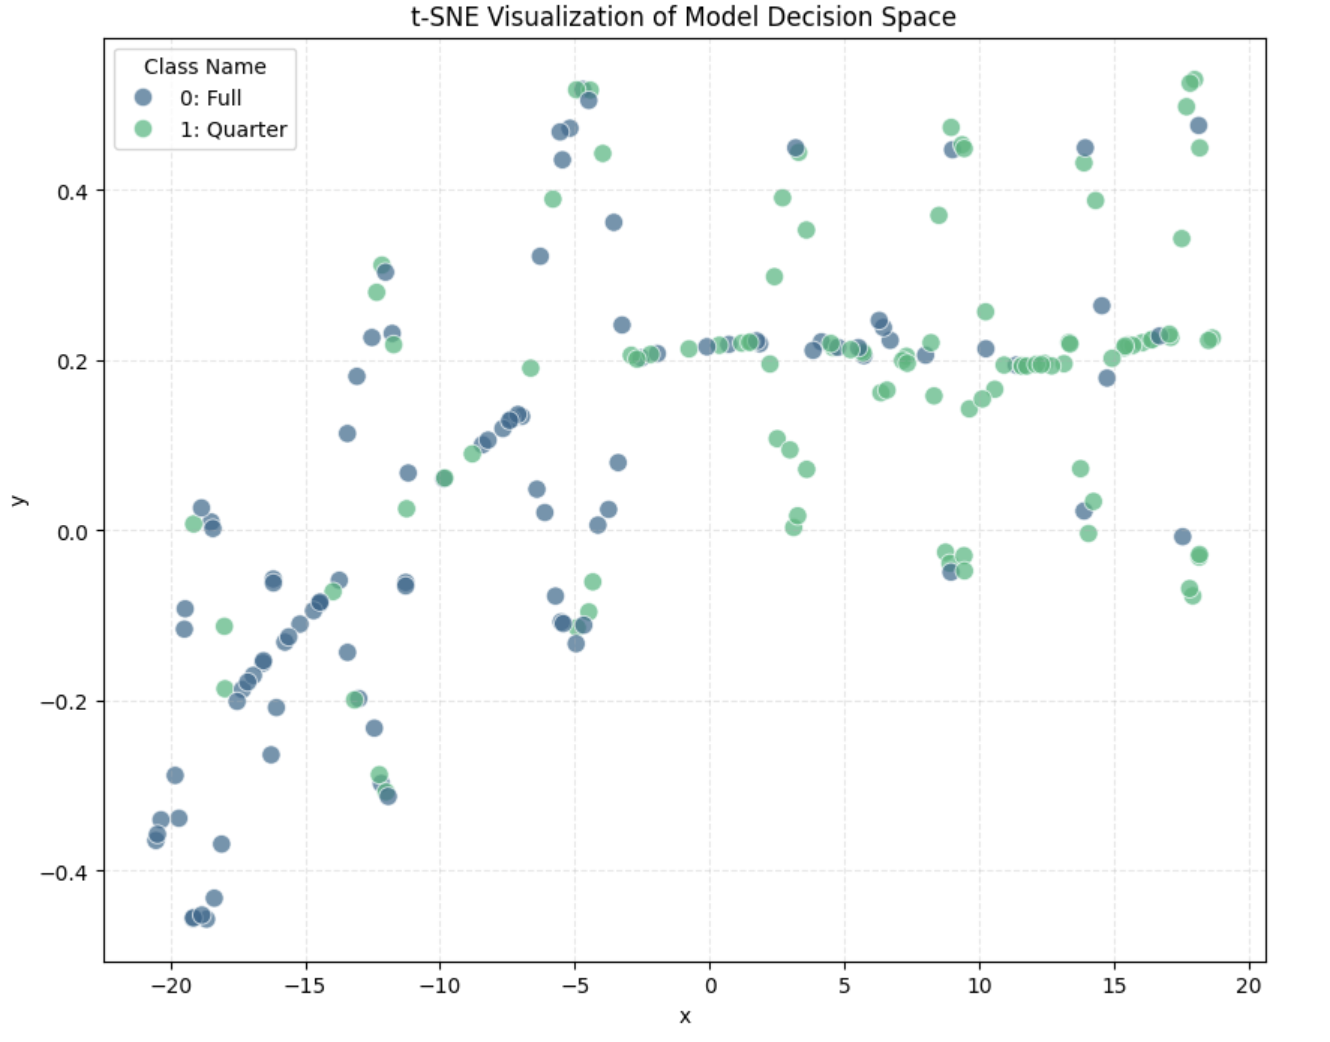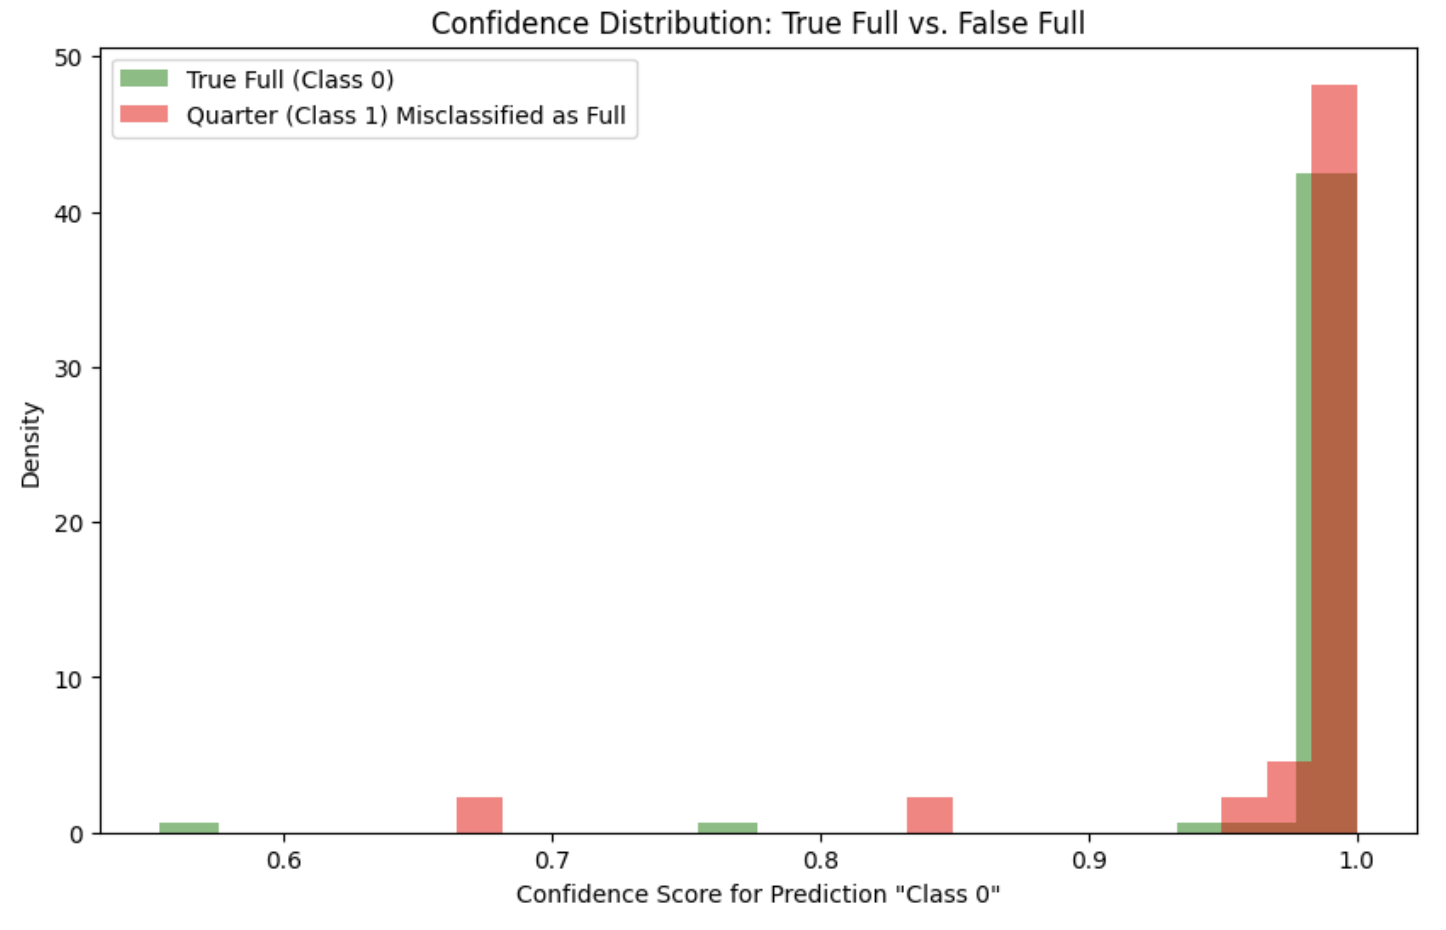

### 4.4 Evaluation on New Data

In [ ]:
import os
import glob
import numpy as np
import torch

def preprocess_npz_to_tensor(npz_path, t_target=64):
    """
    Load one skeleton npz and apply the same preprocessing
    as in SimplePoseSeqDataset, returning a tensor [1, C, T].
    """
    # Load npz, expect "keypoints" of shape [T, 33, 3]
    z = np.load(npz_path, allow_pickle=True)
    kp = z["keypoints"].astype(np.float32)   # [T, 33, 3]
    xy = kp[:, :, :2]                        # [T, 33, 2]
    T  = xy.shape[0]

    # 1) Translate so that mid-hip is at (0, 0)
    xy3 = kp  # reuse kp with visibility
    for t in range(T):
        mx, my = mid_hip_xy(xy3[t])
        xy[t, :, 0] -= mx
        xy[t, :, 1] -= my

    # 2) Scale by trunk height (median over time)
    s_seq = np.median([trunk_height(xy3[t]) for t in range(T)]).astype(np.float32)
    xy /= (s_seq + 1e-8)

    # 3) Flatten joints: [T, 33, 2] -> [T, 66]
    seq = xy.reshape(T, -1)

    # 4) Temporal smoothing with 3-frame moving average
    seq = smooth3(seq)

    # 5) Velocity features: first-order difference over time
    vel = np.zeros_like(seq)
    vel[1:] = seq[1:] - seq[:-1]

    # 6) Resample sequence and velocity to fixed length t_target
    seq = linear_resample(seq, t_target)
    vel = linear_resample(vel, t_target)

    # 7) Concatenate position and velocity: [T, 66+66] = [T, 132]
    feat = np.concatenate([seq, vel], axis=1)

    # 8) Per-sequence normalization (mean/std over time)
    mean = feat.mean(axis=0, keepdims=True)
    std  = feat.std(axis=0, keepdims=True) + 1e-6
    feat = (feat - mean) / std

    # 9) Convert to tensor [1, C, T] for the model
    x = torch.from_numpy(feat.T).float().unsqueeze(0).to(device)
    return x

def infer_single_npz(npz_path, t_target=64):
    """
    Run model inference on one npz file.
    Returns (predicted_class_index, probabilities_vector).
    """
    x = preprocess_npz_to_tensor(npz_path, t_target=t_target)  # [1, C, T]
    with torch.no_grad():
        logits = model(x)                      # [1, num_classes]
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred  = int(probs.argmax())
    return pred, probs

In [ ]:
import os
import glob
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to your best checkpoint
ckpt_path = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/checkpoints/tiny_tcn_best.pt"
state = torch.load(ckpt_path, map_location=device)

print("Checkpoint keys:", state.keys())

# ===== 1. Extract model_state and infer num_classes from weights/config =====
if "model_state" in state:
    model_state = state["model_state"]
elif "model" in state:
    model_state = state["model"]
else:
    model_state = state

# From weights (ground truth)
fc2_w = model_state["fc2.weight"]        # shape: [num_classes, 128]
num_classes_from_weight = fc2_w.shape[0]
print("fc2.weight shape in checkpoint:", fc2_w.shape)

# From config (also says 2)
cfg = state.get("config", {}) or {}
num_classes_from_cfg = cfg.get("NUM_CLASSES", num_classes_from_weight)
print("NUM_CLASSES in config:", num_classes_from_cfg)

# Final num_classes: trust the weights/config (both are 2 in your case)
num_classes = num_classes_from_cfg
print("=> Using num_classes:", num_classes)

# Just for reference: raw class_map (4 keys but 2 merged classes)
raw_class_map = state.get("class_map", None)
print("class_map in checkpoint:", raw_class_map)

# ===== 2. Define class index -> name (merged 2-class setting) =====
# You merged: full -> 0, q/under/down -> 1
IDX_TO_NAME = {
    0: "clean",
    1: "q/under/down",
}

# Safety: if for some reason num_classes != 2, fall back to generic
if num_classes != 2:
    IDX_TO_NAME = {i: f"class_{i}" for i in range(num_classes)}
    print("Warning: num_classes is not 2, using generic IDX_TO_NAME:", IDX_TO_NAME)
else:
    print("Using merged 2-class names:", IDX_TO_NAME)

# ===== 3. Build model and load weights =====
model = TinyTCN(
    c_in=132,          # 33 joints * 2 (xy) + 33 joints * 2 (vel) = 132
    num_classes=num_classes,
    p_drop=0.2         # must match training configuration
).to(device)

print("Fresh TinyTCN fc2 shape:", model.fc2.weight.shape)

model.load_state_dict(model_state)
model.eval()
print("Model loaded from:", ckpt_path)
print("Loaded fc2 shape:", model.fc2.weight.shape)

# ===== 4. Inference on all npz files under coord_dir =====

# Root directory containing new npz files (possibly with subfolders)
coord_dir = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/2025SA_WOMEN_clips_test/Skeleton_Coords"

# Recursively find all *.npz under coord_dir
npz_files = glob.glob(os.path.join(coord_dir, "**", "*.npz"), recursive=True)
npz_files = sorted(npz_files)
print("Found npz files:", len(npz_files))

results = []

for p in npz_files:
    # infer_single_npz must be defined in a previous cell
    pred_idx, probs = infer_single_npz(p, t_target=64)
    pred_name = IDX_TO_NAME.get(pred_idx, str(pred_idx))
    print(f"{p} -> pred_idx={pred_idx}, pred_name={pred_name}, probs={probs}")
    results.append((p, pred_idx, pred_name, probs))

print("Inference finished.")


### 4.5 Discussion of Results

Based on the visualizations and error analysis generated above, we observe a distinct pattern in the model's performance, specifically regarding the boundary between **Class 0 (Clean/Full)** and **Class 1 (Faults)**.

**1. The "Full" vs. "Quarter" Challenge**
The t-SNE feature projection reveals that while the model easily distinguishes severe faults (such as "Downgraded" or obvious "Under-rotations") from clean jumps, there is significant overlap in the latent space between:
* **Full Rotation (Class 0)**
* **On the Quarter (Subset of Class 1)**

**2. Understanding the "Ambiguous Boundary" (Misclassification)**
Most errors occur in this specific overlap zone. Unlike distinct categories (e.g., a fall vs. a stand), the difference between a "Full" jump and a "Quarter" deduction is often a matter of less than 90 degrees of rotation.
* **Why errors happen:** The skeletal data for these two cases are mathematically extremely similar. The model struggles to find a sharp cutoff line because the visual "distance" between a clean landing and a slightly short landing is minimal.
* **Result:** Clean jumps are occasionally flagged as faults (False Positives), and subtle under-rotations are sometimes missed (False Negatives) because they sit on this fuzzy border.

**3. Conclusion & Hardware Improvements**
This difficulty mirrors human judging, where the "Quarter" call is notoriously subjective. To resolve this bottleneck and capture more useful information, future iterations should upgrade the data acquisition hardware:
* **Depth Cameras (e.g., LiDAR/Stereo):** To capture direct 3D depth information (Z-axis) rather than inferring it from 2D video, allowing for precise measurement of blade angles relative to the ice.
* **High-Definition & High-Frame-Rate Cameras:** To reduce motion blur during the fast landing phase, ensuring that the exact moment of impact is captured with sufficient clarity for the model to detect subtle rotation deficits.

**4. Future Directions**
We identify three main directions for improving our model: 
- **Real Time Analysis:** move from using pre-extracted skeleton sequences to integrating a real-time pose pipeline so that we can perform online jump segmentation and subsequent rotation-count detection; 
- **Key Frame Selection:** explicitly detect and extract the key take-off and landing frames, which are the most critical for determining whether the jump satisfies the required number of rotations according to judging rules; 
- **introducing ROI:** introduce a foot-focused ROI module to refine lower-limb joint estimation and correction, aiming for more accurate and robust scoring.

In [ ]:
%%shell
jupyter nbconvert --to html /content/FS_TCN.ipynb

[NbConvertApp] Converting notebook /content/FS_TCN.ipynb to html
[NbConvertApp] Writing 3861456 bytes to /content/FS_TCN.html
